# Humoral race

## Imports

In [1]:
import datetime
import os
from tqdm import tqdm
import h5py

import pandas as pd
import numpy as np

import scipy
from scipy import stats
from sklearn.model_selection import train_test_split
import confidenceinterval

import torch
from torch import nn
import torch.utils.data as data
import lightning as pl

from matplotlib import gridspec
from matplotlib.colors import ListedColormap
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.pyplot import *
import matplotlib.font_manager as font_manager
import seaborn as sns

pingouin_available = False
statannotations_available = False

try:
    import pingouin as pg

    pingouin_available = True
    print("Using pingouin package for partial correlations")
except:
    pingouin_available = False

try:
    from statannotations.Annotator import Annotator

    statannotations_available = True
    print("Using statannotations package for boxplot star annotations")
except:
    statannotations_available = False

Using pingouin package for partial correlations
Using statannotations package for boxplot star annotations


## Define graphic parameters and declare functions used to plot figures

In [2]:
try:
    mpl.colormaps.unregister("mg_custom_cmap")
except:
    pass
mpl.colormaps.register(cmap=ListedColormap(["#eaecee", "#aed6f1", "#7393B3", "#17202a"], name="mg_custom_cmap"))

# graphical parameters, for article figures:
pp_size = 6
legend_font_params = font_manager.FontProperties(family='Calibri',
                                                 weight='normal',
                                                 style='normal',
                                                 size=24)
paneltitle_font_params = font_manager.FontProperties(family='Calibri',
                                                     weight='bold',
                                                     style='normal',
                                                     size=24)
labels_font_params = {"fontname": "Calibri", "fontweight": "normal", "fontsize": 24}
ticks_font_params = {'family': 'Calibri', 'weight': 'normal', 'size': 22}
scatter_plot_size = 120
boxplot_mean_marker_size = 10
boxplot_lw = 4.0
boxplot_precise_lw = 1.0
boxplot_props = {
    'flierprops': {"markersize": boxplot_mean_marker_size},
    'meanprops': {"marker": "X", "markeredgecolor": "#333333", "markerfacecolor": "#333333", "markersize": boxplot_mean_marker_size}}

rcParams['axes.facecolor'] = 'white'
# rcParams['axes.edgecolor'] = 'black'
rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.it'] = 'Calibri:italic'
rcParams['mathtext.rm'] = 'Calibri'
rcParams['mathtext.bf'] = 'Calibri:bold'
rc_params = {'font.size': 16, }
plt.rcParams.update(rc_params)

# quick function to do regression plot
def plot_lm(x, y, group_name, xlabel, ylabel, xticks=None, yticks=None, show_grid: bool = True,
            correlation_method=("spearman", "pearson")[1],
            n_xticks: int = 7, n_yticks: int = 7, suptitle: str = None,
            scatter_plot_custom_size: float = scatter_plot_size, scatter_kws_custom_alpha: float = 0.5,
            text_show: bool = True, text_show_sample_size: bool = True, text_bbox_alpha: float = .0, text_pos: str = "top left",
            verticalalignment=None, horizontalalignment=None,
            common_scale: bool = False, no_lm: bool = False,
            console_print_pr: bool = False,
            confidence_level: float = None):
    from scipy import stats
    from sklearn.linear_model import LinearRegression

    x = x.to_numpy() if type(x) is pd.Series else x
    x = np.array(x) if type(x) in (list, tuple) else x
    y = y.to_numpy() if type(y) is pd.Series else y
    y = np.array(y) if type(y) in (list, tuple) else y
    xmin, xmax, ymin, ymax = x.min(), x.max(), y.min(), y.max()
    xymin, xymax = min(x.min(), y.min()), max(x.max(), y.max())
    xyrange = xymax - xymin
    xrange, yrange = xmax - xmin, ymax - ymin
    if correlation_method == "pearson":
        # r, p = scipy.stats.pearsonr(x=x, y=y)
        cor_method = stats.pearsonr
    elif correlation_method == "spearman":
        # r, p = scipy.stats.spearmanr(a=x, b=y)
        cor_method = stats.spearmanr
    else:
        assert False, f"Unsupported {correlation_method=}"
    r, p = cor_method(x, y)
    if confidence_level is not None:
        assert (confidence_level > .5) and (confidence_level < 1), f"Unexpected {confidence_level=}"
        bts_results = stats.bootstrap((x, y), cor_method, paired=True, n_resamples=9999, confidence_level=confidence_level, random_state=1)
        r_lo = bts_results.confidence_interval[0][0]
        r_hi = bts_results.confidence_interval[1][0]
    else:
        r_lo, r_hi = None, None

    lm = LinearRegression()
    lm.fit(X=x.reshape(-1, 1), y=y.reshape(-1, 1))
    # slope, intercept = lm.coef_[0][0], lm.intercept_[0]
    if common_scale:
        xmin, xmax, xrange, ymin, ymax, yrange = xymin, xymax, xyrange, xymin, xymax, xyrange
        ax = sns.lineplot(x=[0, xymax], y=[0, xymax], linestyle='--', color="#aaaaaa")
        scatter_kws = {"color": "black", "alpha": scatter_kws_custom_alpha, "s": scatter_plot_custom_size}
        if no_lm:
            sns.scatterplot(x=x, y=y, **scatter_kws, ax=ax)
        else:
            sns.regplot(x=x, y=y, scatter_kws=scatter_kws, line_kws={"color": "red"}, ax=ax)
    else:
        scatter_kws = {"color": "black", "alpha": scatter_kws_custom_alpha, "s": scatter_plot_custom_size}
        if no_lm:
            ax = sns.scatterplot(x=x, y=y, **scatter_kws)
        else:
            ax = sns.regplot(x=x, y=y, scatter_kws=scatter_kws, line_kws={"color": "red"})
    # reset ymin, max, etc. based on xticks yticks
    if (xticks is not None) and (len(xticks) > 0):
        xmin = min(xmin, min(xticks))
        xmax = max(xmax, max(xticks))
    if (yticks is not None) and (len(yticks) > 0):
        ymin = min(ymin, min(yticks))
        ymax = max(ymax, max(yticks))
    xrange = xmax - xmin
    yrange = ymax - ymin
    if text_pos.split(" ")[0] == "top":
        text_y = ymin + yrange * .98
        if verticalalignment is None:
            verticalalignment = "top"
    else:
        text_y = ymin + yrange * .02
        if verticalalignment is None:
            verticalalignment = "bottom"
    if text_pos.split(" ")[1] == "left":
        text_x = xmin + xrange * .02
        if horizontalalignment is None:
            horizontalalignment = "left"
    else:
        text_x = xmax - xrange * .02
        if horizontalalignment is None:
            horizontalalignment = "right"
    if text_show:
        if no_lm and text_show_sample_size:
            if (group_name is not None) and (len(group_name) > 0):
                lm_text = f'{group_name}: '
            else:
                lm_text = ""
            lm_text += r'$\it{n}$' + f' = {len(x)}'
        elif (not no_lm) and text_show_sample_size:
            if (group_name is not None) and (len(group_name) > 0):
                lm_text = f'{group_name}: '
            else:
                lm_text = ""
            lm_text += r'$\it{n}$' + f' = {len(x)}' + '\n' + r"$\it{r}$" + f' = {r:.2f}'
            if confidence_level is not None:
                lm_text += f" ({r_lo:.2f}, {r_hi:.2f})"
        elif (not no_lm) and (not text_show_sample_size):
            lm_text = (r"$\it{r}$" + f' = {r:.2f}')
            if confidence_level is not None:
                lm_text += f" ({r_lo:.2f}, {r_hi:.2f})"
        else:
            lm_text = ""
            text_show = False
        if text_show:
            plt.text(text_x, text_y,
                     # '\n' + '$\it{slope} = $' + f'{slope:.1f}' + ', $\it{intercept} = $' + f'{intercept:.1f}' +
                     lm_text,
                     verticalalignment=verticalalignment,
                     horizontalalignment=horizontalalignment,
                     font=legend_font_params,
                     bbox=dict(facecolor='white', alpha=text_bbox_alpha) if text_bbox_alpha > 0 else None)
    if common_scale:
        plt.xlim(xymin, xymax)
        plt.ylim(xymin, xymax)
    if xticks is not None:
        plt.xticks(xticks)
    else:
        plt.locator_params(axis='x', nbins=n_xticks)
    xticks = ax.get_xticks()
    if (xticks % 1 == 0).all():
        xticks = xticks.astype(int)
    round_yticks = False
    if yticks is not None:
        plt.yticks(yticks)
    else:
        round_yticks = True
        plt.locator_params(axis='y', nbins=n_yticks)
    yticks = ax.get_yticks()
    if (yticks % 1 == 0).all():
        yticks = yticks.astype(int)
    elif round_yticks:
        # round intelligently
        n_decimalzeros = np.ceil(-np.log10((np.max(yticks) - np.min(yticks)) / 100))
        yticks = np.round(yticks, n_decimalzeros)
    ax.set_xticklabels(xticks, fontdict=ticks_font_params)
    ax.set_yticklabels(yticks, fontdict=ticks_font_params)
    plt.ylabel(ylabel, **labels_font_params)
    plt.xlabel(xlabel, **labels_font_params)
    if show_grid:
        plt.grid(color='#aaaaaa', linewidth=0.5)
    if suptitle is not None:
        plt.title(suptitle, loc='left', font=paneltitle_font_params)
    if console_print_pr:
        print(f"r={r:.2f}, p={p:.1g}")
    return ax


# quick function to do regression
def plot_box(x, y, hue, xlabel, ylabel, yticks=None, n_yticks: int = 5, showmeans: bool = True, suptitle: str = None,
             legend_loc: str = None, legend_off: bool = False,
             data=None, palette=None,
             show_grid: bool = True,
             subtype="boxplot",
             swarmsize=None,
             display_n_obs=True,
             ax=None):
    # the actual box plot
    # ax = None
    if subtype == "boxplot":
        ax = sns.boxplot(data=data, x=x, y=y, hue=hue,
                         ax=ax,
                         palette=palette,
                         linewidth=boxplot_lw,
                         notch=False,
                         # saturation=1.,
                         **boxplot_props,
                         showmeans=showmeans)
    elif subtype == "violinplot":
        ax = sns.violinplot(data=data, x=x, y=y, hue=hue,
                            ax=ax,
                            palette=palette,
                            linewidth=boxplot_lw,
                            # **boxplot_props,
                            # showmeans=showmeans,
                            )
    elif subtype == "precise_violinplot":
        ax = sns.violinplot(data=data, x=x, y=y, hue=hue,
                            ax=ax,
                            palette=palette,
                            linewidth=boxplot_precise_lw,
                            # **boxplot_props,
                            # showmeans=showmeans,
                            )
    elif subtype == "precise_violinplot+swarmplot":
        ax = sns.violinplot(data=data, x=x, y=y, hue=hue,
                            ax=ax,
                            palette=palette,
                            linewidth=boxplot_precise_lw,
                            # **boxplot_props,
                            # showmeans=showmeans,
                            )
        sns.swarmplot(data=data, x=x, y=y, hue=hue,
                      ax=ax,
                      dodge=True,
                      color="#999999",
                      alpha=.9,
                      # palette=palette,
                      size=1 if swarmsize is None else swarmsize,
                      )
    elif subtype == "stripplot":
        ax = sns.stripplot(data=data, x=x, y=y, hue=hue,
                           ax=ax,
                           palette=palette,
                           # linewidth=boxplot_lw,
                           # saturation=1.,
                           # **boxplot_props,
                           # showmeans=showmeans,
                           )
    elif subtype == "swarmplot":
        ax = sns.swarmplot(data=data, x=x, y=y, hue=hue,
                           ax=ax,
                           dodge=True,
                           palette=palette,
                           size=1,
                           # linewidth=boxplot_lw,
                           # saturation=1.,
                           # **boxplot_props,
                           # showmeans=showmeans,
                           )
    else:
        assert False, f"Unknown {subtype=}"
    # ticks and labels
    if yticks is not None:
        plt.yticks(yticks)
    else:
        plt.locator_params(axis='y', nbins=n_yticks)
    yticks = ax.get_yticks()
    if (yticks % 1 == 0).all():
        yticks = yticks.astype(int)
    xticks = ax.get_xticks()
    if (data is not None) and (type(x) is str):
        if data[x].dtype.name == "category":
            xticks = [data[x].cat.categories[v] for v in xticks]
    elif type(x) is pd.Series:
        if x.dtype.name == "category":
            xticks = [x.cat.categories[v] for v in xticks]
    ax.set_xticklabels(xticks, fontdict=ticks_font_params)
    ax.set_yticklabels(yticks, fontdict=ticks_font_params)
    plt.ylabel(ylabel, **labels_font_params)
    plt.xlabel(xlabel, **labels_font_params)
    if suptitle is not None:
        plt.title(suptitle, loc='left', font=paneltitle_font_params)
    # grid
    if show_grid:
        ax.set_axisbelow(True)
        ax.yaxis.grid(color='#aaaaaa', linewidth=0.5)
        # plt.grid(axis="y", color='#aaaaaa', linewidth=0.5)
    # display n
    if display_n_obs:
        # assert hue is None, "Cannot compute text for n_obs if hue is not None!"
        assert data is not None, "Cannot compute text for n_obs if data is None!"
        # medians = data.groupby([x])[y].median().values
        ylo, yhi = ax.get_ylim()
        y0pos = ylo + (yhi - ylo) * .01
        if hue is None:
            # nobs = boxplot_kwargs["data"][boxplot_kwargs["x"]].value_counts().values
            nobs = data[x].value_counts().values
            nobs = [str(x) for x in nobs.tolist()]
            nobs = ["n=" + i for i in nobs]
        else:
            nobs = []
            # for x_possible_value in list(boxplot_kwargs["data"][boxplot_kwargs["x"]].cat.categories):
            #     n_by_hue = []
            #     for hue_possible_value in list(boxplot_kwargs["data"][boxplot_kwargs["hue"]].cat.categories):
            #         n_here = ((boxplot_kwargs["data"][boxplot_kwargs["x"]] == x_possible_value) & (boxplot_kwargs["data"][boxplot_kwargs["hue"]] == hue_possible_value)).sum()
            #         n_by_hue.append(n_here)
            #     nobs.append(n_by_hue)
            for x_possible_value in list(data[x].cat.categories):
                n_by_hue = []
                for hue_possible_value in list(data[hue].cat.categories):
                    n_here = ((data[x] == x_possible_value) & (data[hue] == hue_possible_value)).sum()
                    n_by_hue.append(n_here)
                nobs.append(n_by_hue)
            nobs = [["n=" + str(x) for x in xlist] for xlist in nobs]

        pos = range(len(nobs))
        for tick, label in zip(pos, ax.get_xticklabels()):
            if type(nobs[tick]) is list:
                hueobs = nobs[tick]
                space_between_ticks = 1 / (len(hueobs) + 1)
                ticks_range = (len(hueobs) - 1) * space_between_ticks
                tick_start = 0 - (ticks_range / 2)
                for ti, nobs_hue in enumerate(hueobs):
                    ax.text(pos[tick] + tick_start + ti * space_between_ticks,
                            # medians[tick] + 0.03,
                            y0pos,
                            nobs_hue,
                            horizontalalignment='center',
                            size='x-small',
                            color='black', )
            else:
                ax.text(pos[tick],
                        # medians[tick] + 0.03,
                        y0pos,
                        nobs[tick],
                        horizontalalignment='center',
                        size='x-small',
                        color='black', )
    # legend
    if not legend_off:
        if legend_loc == "outside":
            ax.legend(prop=legend_font_params, bbox_to_anchor=(1.04, 0.5), loc="center left")
        else:
            ax.legend(prop=legend_font_params, loc=legend_loc)
    return ax


def plot_roc(y, y_, suptitle: str = None, display_n: bool = False, text_bbox_alpha: float = .0, confidence_level: float = None):
    if confidence_level is not None:
        assert (confidence_level > 0) and (confidence_level < 1), f"Unexpected {confidence_level=}"

        t = np.concatenate([[np.Inf, ], np.sort(np.unique(y_))[::-1]])
        tpr, tpr_lo, tpr_hi, fpr, fpr_lo, fpr_hi = [], [], [], [], [], []
        for thresh in t:
            thresh_tpr, (thresh_tpr_lo, thresh_tpr_hi) = confidenceinterval.tpr_score(y, (y_ >= thresh) * 1, confidence_level=confidence_level)
            thresh_fpr, (thresh_fpr_lo, thresh_fpr_hi) = confidenceinterval.fpr_score(y, (y_ >= thresh) * 1, confidence_level=confidence_level)
            tpr.append(thresh_tpr)
            tpr_lo.append(thresh_tpr_lo)
            tpr_hi.append(thresh_tpr_hi)
            fpr.append(thresh_fpr)
            fpr_lo.append(thresh_fpr_lo)
            fpr_hi.append(thresh_fpr_hi)
        tpr, tpr_lo, tpr_hi, fpr, fpr_lo, fpr_hi = np.array(tpr), np.array(tpr_lo), np.array(tpr_hi), np.array(fpr), np.array(fpr_lo), np.array(fpr_hi)

        roc_auc, (roc_auc_lo, roc_auc_hi) = confidenceinterval.roc_auc_score(y, y_, confidence_level=confidence_level)

    else:
        # using sklearn
        from sklearn import metrics

        fpr, tpr, t = metrics.roc_curve(y, y_)
        tpr_lo, tpr_hi, fpr_lo, fpr_hi = None, None, None, None
        roc_auc = metrics.auc(fpr, tpr)
        roc_auc_lo, roc_auc_hi = None, None

    # confidenceinterval.roc_auc_score(y_true=balanced_df["Binary race"], y_pred=balanced_df[peak_method])

    # Plot curve
    plt.plot([0, 1], [0, 1], color='#aaaaaa', lw=2, linestyle='--')

    if confidence_level is not None:
        plt.fill_between(x=fpr, y1=tpr_lo, y2=tpr_hi, color='black', alpha=.1)
        plt.plot(fpr, tpr, color='black', lw=2, label=f'AUC={roc_auc:0.2f} ({roc_auc_lo:0.2f}-{roc_auc_hi:0.2f})')
    else:
        plt.plot(fpr, tpr, color='black', lw=2, label=f'AUC={roc_auc:0.2f}')

    if display_n:
        plt.text(.05, .95,
                 '$\it{n}$' + f' = {len(y)}',
                 verticalalignment="top",
                 horizontalalignment="left",
                 font=legend_font_params,
                 bbox=dict(facecolor='white', alpha=text_bbox_alpha) if text_bbox_alpha > 0 else None)

    # Set boundaries, labels, titles...
    plt.xlim([0., 1.])
    plt.ylim([0., 1.])

    ax = plt.gca()
    xticks = np.round(100 * ax.get_xticks(), 0).astype(int)
    yticks = np.round(100 * ax.get_yticks(), 0).astype(int)
    ax.set_xticklabels(xticks, fontdict=ticks_font_params)
    ax.set_yticklabels(yticks, fontdict=ticks_font_params)

    plt.xlabel('False Positive Rate', **labels_font_params)
    plt.ylabel('True Positive Rate', **labels_font_params)
    if suptitle is not None:
        plt.title(suptitle, loc='left', font=paneltitle_font_params)
        # plt.title(suptitle)
    plt.legend(loc="lower right")
    plt.tight_layout()
    return ax


# quick function to do regression
def plot_paired_box(data, x, y, xlabel, ylabel, yticks=None, n_yticks: int = 7, showmeans: bool = False, suptitle: str = None,
                    legend_loc: str = None, legend_off: bool = False, palette=None, points_palette=None):
    # the actual box plot
    ax = sns.boxplot(data=data, x=x, y=y,
                     palette=palette,
                     linewidth=boxplot_lw,
                     notch=False,
                     # saturation=1.,
                     **boxplot_props,
                     showmeans=showmeans)
    scatter_kws = {"alpha": 1.0, "s": scatter_plot_size}
    sns.scatterplot(data=data, x=x, y=y, ax=ax, **scatter_kws, palette=points_palette, hue=x)
    x1, x2 = data[x].unique()
    for y1, y2 in zip(data[data[x] == x1][y].tolist(), data[data[x] == x2][y].tolist()):
        lcolor = "#ff0000" if y2 > y1 else "#0000ff"
        sns.lineplot(x=[x1, x2], y=[y1, y2], ax=ax, color=lcolor)
    # ticks and labels
    if yticks is not None:
        plt.yticks(yticks)
    else:
        plt.locator_params(axis='y', nbins=n_yticks)
    yticks = ax.get_yticks()
    if (yticks % 1 == 0).all():
        yticks = yticks.astype(int)
    xticks = ax.get_xticks()
    if (data is not None) and (type(x) is str):
        if data[x].dtype.name == "category":
            xticks = [data[x].cat.categories[v] for v in xticks]
    elif type(x) is pd.Series:
        if x.dtype.name == "category":
            xticks = [x.cat.categories[v] for v in xticks]
    ax.set_xticklabels(xticks, fontdict=ticks_font_params)
    ax.set_yticklabels(yticks, fontdict=ticks_font_params)
    plt.ylabel(ylabel, **labels_font_params)
    plt.xlabel(xlabel, **labels_font_params)
    if suptitle is not None:
        plt.title(suptitle, loc='left', font=paneltitle_font_params)
    # legend
    if not legend_off:
        if legend_loc == "outside":
            ax.legend(prop=legend_font_params, bbox_to_anchor=(1.04, 0.5), loc="center left")
        else:
            ax.legend(prop=legend_font_params, loc=legend_loc)
    else:
        ax.legend_.remove()
    return ax

Set dataset path

In [3]:
for dropbox_path in [r"C:\Users\flori\Dropbox (Partners HealthCare)", r"C:\Users\f.chabrun\Partners HealthCare Dropbox\Floris Chabrun"]:
    if os.path.exists(dropbox_path):
        print(f"Found DROPBOX folder")
        checkpoint_path = os.path.join(dropbox_path, r"Floris\SPECTR-MS\out\checkpoints", r"v92_race_v2\v2_base_batch_size_32",
                                       "epoch=39-step=8400.ckpt")
        dataset_dir = os.path.join(dropbox_path, 'Floris/SPECTR-MS/data/v9.0/dataset')
        break

Found DROPBOX folder


Set various parameters that will be used for deep learning analysis (e.g. input size, batch size, etc.)

In [4]:
input_dim = 1536
batch_size = 32
training_coarse_dropout = {
    "n_binom_n": 10,
    "n_binom_p": 0.5,
    "width_binom_n": 200,
    "width_binom_p": 0.5
}
prediction_target = "RACE"

Load dataset, and pre-process: filter out samples not passing QC, perform some statistics

In [5]:
dataset = pd.DataFrame(pd.read_hdf(os.path.join(dataset_dir, "dataset_final.h5"), key="dataset"))
dataset_backup = dataset.copy()
print(f"Loaded dataset with {dataset.shape=}")

dataset = dataset.loc[dataset.QC_MSRAW_Data_Available, :]
print(f"    > Filtered to {dataset.shape=} after removing missing/invalid MS data")
dataset = dataset.loc[~dataset.QC_MS_Noise_Filter_Triggered, :]
print(f"    > Filtered to {dataset.shape=} after removing noisy samples")

# remove patients with unavailable MS_DIAGNOSIS
filt = dataset.GLOBAL_DIAGNOSIS.isin(["Negative", "MGUS", "MGIP-High", "MGIP-Low", "LC-MGUS"])
print("dataset statistics:")
print("")
print(f"{len(dataset)=}")
print("")
print("dataset.COHORT2")
print(dataset.COHORT2.value_counts().to_string())
print("")
print("dataset.GLOBAL_DIAGNOSIS")
print(dataset.GLOBAL_DIAGNOSIS.value_counts().to_string())
print("")
print("Earliest date: ", end="")
print((pd.to_datetime(dataset.SAMPLE_DATE)).min())
print("Latest date: ", end="")
print((pd.to_datetime(dataset.SAMPLE_DATE)).max())
print("")
print("dataset.RACE")
print(dataset.RACE.value_counts().to_string())
print("")
print("dataset.SEX")
print(dataset.SEX.value_counts().to_string())
print("dataset.AGE")
print(np.nanquantile(dataset.AGE, [.25, .5, .75]))
print("")
print("dataset.ETHNIC_GROUP")
print(dataset.ETHNIC_GROUP.value_counts().to_string())

print(pd.crosstab(dataset.MS_DIAGNOSIS, dataset.GLOBAL_DIAGNOSIS).to_string())

# create the batch variable, using the plate barcode (barcodes are ordered, lowest = oldest batch, highest = latest batch)
plate_barcode_batch_dict = {plate_barcode: index + 1 for index, plate_barcode in
                            enumerate(dataset.PLATE_BARCODE_BATCH.astype(int).sort_values().unique())}

# check properly correlated
ordered_plate_barcodes = np.array([k for k, v in plate_barcode_batch_dict.items()])
ordered_batches = np.array([plate_barcode_batch_dict[k] for k in ordered_plate_barcodes])
assert (np.argsort(ordered_plate_barcodes) == np.arange(len(ordered_plate_barcodes))).all()
assert (np.argsort(ordered_batches) == np.arange(len(ordered_batches))).all()

# create the batch variable
dataset["Batch"] = dataset.PLATE_BARCODE_BATCH.astype(int).map(plate_barcode_batch_dict)

# also add "simplified batch", depending on the year the sample was analyzed
dataset["Simplified_Batch"] = dataset.PLATE_BARCODE_BATCH.astype(int).apply(
    lambda b: 1 if b < 22000000 else 2 if b < 22800000 else 3 if b < 24000000 else -1)


PRED_COL = "RACE"
POS_CLASS = "Black"
NEG_CLASS = "White"

dataset = dataset.loc[dataset[PRED_COL].isin([POS_CLASS, NEG_CLASS]), :]

print(f"After removing NA/extreme/unkept values, {dataset.shape=}")

negative_training_filter = (dataset.GLOBAL_DIAGNOSIS.isin(["Negative", ]) &
                            dataset.COHORT.isin(["MGB", "PROMISE_USA", "PROMISE_SA", "PROMISE_SERIAL", ]))
# only negative AND in a screening cohort

positive_leftout_filter = (dataset.GLOBAL_DIAGNOSIS.isin(["MGIP-Low", "MGIP-High", "LC-MGUS", "MGUS"]))
# regardless of the cohort

dataset_intraining = dataset.loc[negative_training_filter, :]  # negative; may have peaks <LLMI, but will have normal FLCr (not pathological)
dataset_outtraining = dataset.loc[positive_leftout_filter, :]  # mgip group, mgus group, LC-MGUS group

print(f"Training (based on MS Diagnosis): {dataset_intraining.shape=}")
if dataset_outtraining is not None:
    print(f"Out of training (based on MS Diagnosis): {dataset_outtraining.shape=}")

x_intraining = dataset_intraining.ANON_ID.tolist()
y_intraining = np.stack([((dataset_intraining[PRED_COL] == NEG_CLASS) * 1).to_numpy(),
                         ((dataset_intraining[PRED_COL] == POS_CLASS) * 1).to_numpy()], axis=-1)
x_outtraining = dataset_outtraining.ANON_ID.tolist()
y_outtraining = np.stack([((dataset_outtraining[PRED_COL] == NEG_CLASS) * 1).to_numpy(),
                          ((dataset_outtraining[PRED_COL] == POS_CLASS) * 1).to_numpy()], axis=-1)

assert (y_intraining.sum(axis=1) == 1).all(), "Some samples do not have y value?"
assert (y_outtraining.sum(axis=1) == 1).all(), "Some samples do not have y value?"

assert np.isfinite(y_intraining).all(), f"Some values in the y array are not finite"

x = x_intraining
y = y_intraining

y_stratify = None


spectrum_files_with_annotations = x
spectrum_annotations_matching = y
spectrum_stratify = y_stratify

print(f"Found {len(spectrum_files_with_annotations)=} labeled samples for supervised training")

Loaded dataset with dataset.shape=(18115, 39)
    > Filtered to dataset.shape=(18052, 39) after removing missing/invalid MS data
    > Filtered to dataset.shape=(17151, 39) after removing noisy samples
dataset statistics:

len(dataset)=17151

dataset.COHORT2
COHORT2
mgb1.0              5318
PSCR_USA            3997
PLCO_MM_NIH1.0      2225
PRM_South_Africa    1985
mgb2.0              1956
PCROWD               726
PRES                 337
PFOL                 274
PSCR                 117
SU2C                  90
nan                   85
PROMISE_PRES          35
MGIP_exp               6

dataset.GLOBAL_DIAGNOSIS
GLOBAL_DIAGNOSIS
Negative               9214
MGUS                   3947
MGIP-High              1783
MGIP-Low               1657
LC-MGUS                 446
nan                      85
MG_not_quantifiable      17
Failure                   2

Earliest date: 2010-07-28 00:00:00
Latest date: 2024-03-01 00:00:00

dataset.RACE
RACE
White                     9684
Black                 

The raw mass spectrometry data (spectra) are stored in a separate dataset
Below we are going to define the functions that can be used to load the spectra from the anonymization IDs listed in the dataset

In [6]:
def load_sample_ms_data(dataset_path: str, match_id: str, peak_removal_method=None):
    if (peak_removal_method is None) or (type(peak_removal_method) in (list, tuple)):  # load raw ms data
        ms_fn = "ms_data.h5"
    else:  # load ms data already preprocessed (peaks dropped out or smoothed)
        ms_fn = f"ms_data_{peak_removal_method}_nopeaks.h5"
    with h5py.File(os.path.join(dataset_path, ms_fn), 'r') as hf:
        x = np.array(hf[match_id])
    if type(peak_removal_method) in (list, tuple):  # manually dropout according to some peaks location information
        for peak_info in peak_removal_method:
            peak_map = (x[0, peak_info["track"], :] >= peak_info["mz_start"]) & (x[0, peak_info["track"], :] <= peak_info["mz_end"])  # locate peak are
            x[1, peak_info["track"], peak_map] = 0  # dropout area
    return x


def _auto_reshape_x(x: np.array, input_dim: int, max_random: int = 0) -> np.array:
    dim = x.shape[-1]
    # handle dim
    if dim < input_dim:
        total_padding = input_dim - dim
        padding_left = total_padding // 2
        if max_random > 0:
            padding_left = np.random.randint(low=max(0, padding_left - max_random), high=min(total_padding, padding_left + max_random) + 1)
        padding_right = total_padding - padding_left
        return np.concatenate([np.tile(x[:, [0]], reps=padding_left), x, np.tile(x[:, [-1]], reps=padding_right)], axis=-1)
    elif dim > input_dim:
        total_remove = dim - input_dim
        remove_left = total_remove // 2
        if max_random > 0:
            # adjust start of the input data by random value
            # min and max would be default pos value +/- max random allowed, clipped to 0/(dim-input_dim)
            remove_left = np.random.randint(low=max(0, remove_left - max_random), high=min(total_remove, remove_left + max_random) + 1)
        return x[:, remove_left:(remove_left + input_dim)]
    return x


class MSSpectraDataset(data.Dataset):
    def __init__(self, dataset_path, sample_match_ids, input_dim, sample_annotations=None,
                 coarse_dropout_parameters=None, peak_removal_method=None, random_crop=0, make_segmentation_maps=False):
        self.dataset_path = dataset_path
        self.sample_match_ids = sample_match_ids
        self.sample_annotations = sample_annotations
        self.input_dim = input_dim
        self.buffered_data = None
        self.coarse_dropout_parameters = coarse_dropout_parameters
        self.peak_removal_method = peak_removal_method
        self.random_crop = random_crop
        self.make_segmentation_maps = make_segmentation_maps

    def __len__(self):
        return len(self.sample_match_ids)

    def __getitem__(self, idx):
        if self.buffered_data is not None:
            return self.buffered_data[idx]
        if (self.peak_removal_method is None) or type(self.peak_removal_method) is str:
            x = load_sample_ms_data(self.dataset_path, self.sample_match_ids[idx], self.peak_removal_method)
        elif type(self.peak_removal_method) in (list, tuple):
            x = load_sample_ms_data(self.dataset_path, self.sample_match_ids[idx], self.peak_removal_method[idx])
        y = None if self.sample_annotations is None else self.sample_annotations[idx]
        if len(x.shape) == 3:
            x = x[1, ...]
        x = _auto_reshape_x(x=x, input_dim=self.input_dim, max_random=self.random_crop)
        # normalize
        xmin = x.min(axis=1, keepdims=True)
        xmax = x.max(axis=1, keepdims=True)
        x = (x - xmin) / (xmax - xmin)
        # random coarse dropouts
        if self.coarse_dropout_parameters is not None:
            cd_params = self.coarse_dropout_parameters
            n_coarse_dropouts = np.random.binomial(cd_params["n_binom_n"], cd_params["n_binom_p"])
            if n_coarse_dropouts > 0:
                # randomly determine dropouts location, size and track
                coarse_dropouts_width = np.random.binomial(cd_params["width_binom_n"], cd_params["width_binom_p"], n_coarse_dropouts)
                coarse_dropouts_track = np.random.uniform(0, 5, n_coarse_dropouts).astype(int)
                coarse_dropouts_center = [np.random.choice(x.shape[-1], p=x[track] / x[track].sum()) for track in coarse_dropouts_track]
                # apply
                for coarse_loc, coarse_width, coarse_track in zip(coarse_dropouts_center, coarse_dropouts_width, coarse_dropouts_track):
                    x[coarse_track, (coarse_loc - coarse_width):(coarse_loc + coarse_width)] = 0
        # reshape
        x = x.reshape((5, 1, self.input_dim))
        # turn to tensor
        x = torch.as_tensor(x, dtype=torch.float32)
        if y is not None:
            return x, y
        return x,

Then we can create our datasets, after separating training and validation samples

In [7]:
spectrum_files_train, spectrum_files_test, spectrum_annotations_train, spectrum_annotations_test = train_test_split(spectrum_files_with_annotations,
                                                                                                                    spectrum_annotations_matching,
                                                                                                                    test_size=.1,
                                                                                                                    random_state=1, shuffle=True,
                                                                                                                    stratify=y_stratify)

train_dataset = MSSpectraDataset(dataset_path=dataset_dir,
                                 sample_match_ids=spectrum_files_train,
                                 sample_annotations=spectrum_annotations_train.astype(np.float32),
                                 input_dim=input_dim,
                                 random_crop=20,
                                 coarse_dropout_parameters=training_coarse_dropout)

test_dataset = MSSpectraDataset(dataset_path=dataset_dir,
                                sample_match_ids=spectrum_files_test,
                                sample_annotations=spectrum_annotations_test.astype(np.float32),
                                input_dim=input_dim)

train_loader = data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=0,
    persistent_workers=False
)

validation_loader = data.DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    drop_last=False,
    pin_memory=True,
    num_workers=0,
    persistent_workers=False
)

## Deep learning pipeline

In [8]:
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps

    def forward(self, yhat, y):
        loss = torch.sqrt(self.mse(yhat, y) + self.eps)
        return loss
    

def _get_homemade_encoder_v1_base_modules(input_dim, input_channels, encoder_blocks_layout, maxpool, kernel_size, stride, dropout,
                                          first_layer_groups, groups, batchnorm, hidden_activation, flatten):

    assert (maxpool == 1 and stride > 1) or (maxpool > 1 and stride == 1), f"Exactly one of {maxpool=} and {stride=} must be > 1"
    n_pools = len(encoder_blocks_layout) - 1 if maxpool > 1 else len(encoder_blocks_layout)

    _encoder_modules = []

    previous_channels = input_channels

    for block_position, block_layers in enumerate(encoder_blocks_layout):
        if block_position > 0:
            if maxpool > 1:
                _encoder_modules.append(nn.MaxPool2d(kernel_size=(1, maxpool), stride=(1, maxpool)))
        for layer_position, layer_channels in enumerate(block_layers):
            current_stride = stride if layer_position == 0 else 1
            padding = 0
            if current_stride > 1:
                hin = input_dim // (max(maxpool, stride) ** (layer_position))
                padding = (kernel_size - hin + stride * (hin / stride - 1)) / 2
                assert (padding % 1) == 0, f"Current {stride}, {hin=} and {kernel_size=} end with decimal {padding=}"
                padding = int(padding)

            _encoder_modules.append(nn.Conv2d(in_channels=previous_channels, out_channels=layer_channels, kernel_size=(1, kernel_size),
                                              stride=(1, current_stride),
                                              groups=first_layer_groups if ((layer_position == 0) and (block_position == 0)) else groups,
                                              padding=(0, padding) if current_stride > 1 else "same"))
            if (dropout is not None) and (dropout > 0):
                _encoder_modules.append(nn.Dropout(p=dropout))
            previous_channels = layer_channels
            if batchnorm:
                _encoder_modules.append(nn.BatchNorm2d(layer_channels))
            if hidden_activation == "relu":
                _encoder_modules.append(nn.ReLU())
            elif hidden_activation == "leaky_relu":
                _encoder_modules.append(nn.LeakyReLU())
            elif hidden_activation == "elu":
                _encoder_modules.append(nn.ELU())
            elif hidden_activation == "selu":
                _encoder_modules.append(nn.SELU())
            else:
                assert False, f"Unknown {hidden_activation=}"

    encoder_lastconv_dim = input_dim // (max(stride, maxpool) ** n_pools)
    encoder_lastconv_channels = encoder_blocks_layout[-1][-1]

    if flatten == "avg":
        global_pooling_kernel = encoder_lastconv_dim
        encoder_output_dim = encoder_lastconv_channels
        _encoder_modules.append(nn.AvgPool2d(kernel_size=(1, global_pooling_kernel)))
        _encoder_modules.append(nn.Flatten())
    elif flatten == "max":
        global_pooling_kernel = encoder_lastconv_dim
        encoder_output_dim = encoder_lastconv_channels
        _encoder_modules.append(nn.MaxPool2d(kernel_size=(1, global_pooling_kernel)))
        _encoder_modules.append(nn.Flatten())
    elif flatten == "flatten":
        encoder_output_dim = encoder_lastconv_channels * encoder_lastconv_dim
        _encoder_modules.append(nn.Flatten())
    else:
        assert False, f"Unknown {flatten=}"

    return _encoder_modules, encoder_output_dim  # , encoder_lastconv_channels, encoder_lastconv_dim


def _get_dense_encoder(input_dim, input_channels, encoder_blocks_layout, dropout, batchnorm, hidden_activation):

    _encoder_modules = []

    previous_size = input_dim * input_channels

    _encoder_modules.append(nn.Flatten())

    for layer_position, layer_size in enumerate(encoder_blocks_layout):

        _encoder_modules.append(nn.Linear(previous_size, layer_size))

        if (dropout is not None) and (dropout > 0):
            _encoder_modules.append(nn.Dropout(p=dropout))
        previous_size = layer_size
        if batchnorm:
            _encoder_modules.append(nn.BatchNorm1d(layer_size))
        if hidden_activation == "relu":
            _encoder_modules.append(nn.ReLU())
        elif hidden_activation == "leaky_relu":
            _encoder_modules.append(nn.LeakyReLU())
        elif hidden_activation == "elu":
            _encoder_modules.append(nn.ELU())
        elif hidden_activation == "selu":
            _encoder_modules.append(nn.SELU())
        else:
            assert False, f"Unknown {hidden_activation=}"

    return _encoder_modules, previous_size



class SupervisedModule(pl.LightningModule):
    def __init__(self, n_classes, mode,
                 input_dim, input_channels, latent_dim, kernel_size, flatten, stride, dropout, groups, first_layer_groups, maxpool,
                 encoder_blocks_layout, backbone, batchnorm, hidden_activation,
                 optimizer,
                 lr, lr_scheduler, lr_reduceonplateau_factor, lr_reduceonplateau_patience, lr_reduceonplateau_threshold, lr_reduceonplateau_minlr,
                 lr_multistep_milestones,
                 lr_multistep_gamma,
                 ):
        super().__init__()
        self.save_hyperparameters()

        self.n_classes = n_classes
        self.mode = mode
        self.backbone = backbone

        if self.backbone == "resnet1d":
            from resnet1d.resnet1d import ResNet1D
            self.encoder = ResNet1D(in_channels=input_channels,
                                    base_filters=encoder_blocks_layout[0][0],
                                    kernel_size=kernel_size,
                                    stride=stride,
                                    groups=groups,
                                    n_block=len(encoder_blocks_layout),
                                    n_classes=n_classes)

        elif self.backbone == "net1d":
            from resnet1d.net1d import Net1D
            self.encoder = Net1D(
                in_channels=input_channels,
                base_filters=encoder_blocks_layout[0][0],
                ratio=1.0,
                filter_list=[f[0] for f in encoder_blocks_layout],
                m_blocks_list=[len(f) for f in encoder_blocks_layout],
                kernel_size=kernel_size,
                stride=stride,
                groups_width=groups,
                verbose=False,
                n_classes=n_classes)

        elif (self.backbone == "conv") or (self.backbone == "homemade"):  # conv model was the first model designed, hence homemade
            encoder_modules, enc_out_dim = _get_homemade_encoder_v1_base_modules(input_dim=input_dim, input_channels=input_channels, maxpool=maxpool,
                                                                                 encoder_blocks_layout=encoder_blocks_layout, kernel_size=kernel_size,
                                                                                 stride=stride, dropout=dropout,
                                                                                 first_layer_groups=first_layer_groups, groups=groups,
                                                                                 batchnorm=batchnorm, hidden_activation=hidden_activation, flatten=flatten)
            self.encoder = nn.Sequential(*encoder_modules)
            self.fc = nn.Linear(enc_out_dim, latent_dim)
            self.pred = nn.Linear(latent_dim, self.n_classes)

        elif self.backbone == "dense":
            encoder_modules, enc_out_dim = _get_dense_encoder(input_dim=input_dim, input_channels=input_channels, encoder_blocks_layout=encoder_blocks_layout,
                                                              dropout=dropout, batchnorm=batchnorm, hidden_activation=hidden_activation)
            self.encoder = nn.Sequential(*encoder_modules)
            # self.fc = nn.Linear(enc_out_dim, latent_dim)
            # self.pred = nn.Linear(latent_dim, self.n_classes)
            self.pred = nn.Linear(enc_out_dim, self.n_classes)
        elif self.backbone == "vit_1d":
            from vit_pytorch import vit_1d

            # for vit we used config parameter "encoder_blocks_layout" in a weird way:
            patch_size = encoder_blocks_layout[0]  # the patch size // defaults 16 from ViT, 20 from ecg classifier
            heads = encoder_blocks_layout[1]  # the number of self attention heads // defaults 6
            depth = encoder_blocks_layout[2]  # the number of layers (depth) // defaults 6
            mlp_dim = encoder_blocks_layout[3]  # the mlp dim // defaults 256
            dim_head = encoder_blocks_layout[4]  # the head dim // defaults 64
            hidden_dim = latent_dim  # the hidden_dim // defaults 768
            # dropout  // defaults 0.1

            vit = vit_1d.ViT(
                seq_len=input_dim,
                patch_size=patch_size,
                num_classes=self.n_classes,
                channels=input_channels,
                dim=hidden_dim,
                dim_head=dim_head,
                depth=depth,
                heads=heads,
                mlp_dim=mlp_dim,
                dropout=dropout,
                emb_dropout=dropout
            )

            self.encoder = vit
        elif self.backbone == "simple_vit_1d":
            from vit_pytorch import simple_vit_1d

            # for vit we used config parameter "encoder_blocks_layout" in a weird way:
            patch_size = encoder_blocks_layout[0]  # the patch size // defaults 16 from ViT, 20 from ecg classifier
            heads = encoder_blocks_layout[1]  # the number of self attention heads // defaults 6
            depth = encoder_blocks_layout[2]  # the number of layers (depth) // defaults 6
            mlp_dim = encoder_blocks_layout[3]  # the mlp dim // defaults 256
            dim_head = encoder_blocks_layout[4]  # the head dim // defaults 64
            hidden_dim = latent_dim  # the hidden_dim // defaults 768
            # dropout  // NO DROPOUT IN SIMPLE VIT!

            vit = simple_vit_1d.SimpleViT(
                seq_len=input_dim,
                patch_size=patch_size,
                num_classes=self.n_classes,
                channels=input_channels,
                dim=hidden_dim,
                dim_head=dim_head,
                depth=depth,
                heads=heads,
                mlp_dim=mlp_dim,
            )

            self.encoder = vit

        elif self.backbone == "smalldataset_vit_1d":
            from python.pyms_assets.vit_1d_for_small_dataset import SDViT

            # for vit we used config parameter "encoder_blocks_layout" in a weird way:
            patch_size = encoder_blocks_layout[0]  # the patch size // defaults 16 from ViT, 20 from ecg classifier
            heads = encoder_blocks_layout[1]  # the number of self attention heads // defaults 6
            depth = encoder_blocks_layout[2]  # the number of layers (depth) // defaults 6
            mlp_dim = encoder_blocks_layout[3]  # the mlp dim // defaults 256
            dim_head = encoder_blocks_layout[4]  # the head dim // defaults 64
            hidden_dim = latent_dim  # the hidden_dim // defaults 768
            # dropout  // NO DROPOUT IN SIMPLE VIT!

            vit = SDViT(
                seq_len=input_dim,
                patch_size=patch_size,
                num_classes=self.n_classes,
                channels=input_channels,
                dim=hidden_dim,
                dim_head=dim_head,
                depth=depth,
                heads=heads,
                mlp_dim=mlp_dim,
                dropout=dropout,
                emb_dropout=dropout
            )

            self.encoder = vit
        else:
            assert False, f"Unknown {backbone=}"

        self.softmax = nn.Softmax(dim=1)

        if self.mode == "quant":
            self.loss = RMSELoss()
        if self.mode == "qual":
            self.loss = nn.CrossEntropyLoss()

        self.y_true = []
        self.y_pred = []

    def configure_optimizers(self):
        if self.hparams.optimizer == "Adam":
            optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr)
        elif self.hparams.optimizer == "AdamW":
            optimizer = torch.optim.AdamW(self.parameters(), lr=self.hparams.lr)
        elif self.hparams.optimizer == "RMSProp":
            optimizer = torch.optim.RMSprop(self.parameters(), lr=self.hparams.lr)
        else:
            assert False, f"Unknown {self.hparams.optimizer=}"
        if self.hparams.lr_scheduler == "reduceonplateau":
            print(
                f"Setting optimizer to reduceonplateau with params {self.hparams.lr_reduceonplateau_factor=}, {self.hparams.lr_reduceonplateau_patience=}, {self.hparams.lr_reduceonplateau_threshold=}, {self.hparams.lr_reduceonplateau_minlr=}")
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=self.hparams.lr_reduceonplateau_factor,
                                                                   patience=self.hparams.lr_reduceonplateau_patience,
                                                                   threshold=self.hparams.lr_reduceonplateau_threshold,
                                                                   min_lr=self.hparams.lr_reduceonplateau_minlr, verbose=True)
            return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}
        elif self.hparams.lr_scheduler == "multistep":
            print(f"Setting optimizer to multistep with params {self.hparams.lr_multistep_milestones=}, {self.hparams.lr_multistep_gamma=}")
            scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=self.hparams.lr_multistep_milestones, gamma=self.hparams.lr_multistep_gamma,
                                                             verbose=True)
            return {"optimizer": optimizer, "lr_scheduler": scheduler}
        elif self.hparams.lr_scheduler != "none":
            assert False, f"Unknown {self.hparams.lr_scheduler=}"
        return optimizer

    def forward(self, batch):
        if type(batch) in (tuple, list):
            x, y = batch
        else:
            x = batch
        if self.backbone in ("resnet1d", "net1d"):
            x = x.view(x.size(0), x.size(1), x.size(3))
            x = self.encoder(x)
        elif self.backbone == "homemade":
            x = self.pred(self.fc(self.encoder(x)))
        elif self.backbone == "dense":
            x = self.pred(self.encoder(x))
        elif self.backbone in ("vit_1d", "simple_vit_1d", "smalldataset_vit_1d"):
            x = torch.squeeze(x)  # drop H in H x W
            x = self.encoder(x)
        if self.mode == "qual":
            x = self.softmax(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch

        # encode x to get the mu and variance parameters
        yhat = None
        if self.backbone in ("resnet1d", "net1d"):
            x = x.view(x.size(0), x.size(1), x.size(3))
            yhat = self.encoder(x)
        elif self.backbone == "homemade":
            yhat = self.pred(self.fc(self.encoder(x)))
        elif self.backbone == "dense":
            yhat = self.pred(self.encoder(x))
        elif self.backbone in ("vit_1d", "simple_vit_1d", "smalldataset_vit_1d"):
            x = torch.squeeze(x)  # drop H in H x W
            yhat = self.encoder(x)

        loss = self.loss(yhat, y)

        self.log_dict({
            'loss': loss,
        })

        return loss

Now we can load the deep learning model and pytorch/lightning objects needed to run the DL pipeline

In [9]:
trainer_args = {'accelerator': 'gpu' if torch.cuda.is_available() else 'cpu',
                'devices': 'auto',
                'num_nodes': 1,
                'strategy': 'auto'}

pl.seed_everything(44)  # To be reproducible
model = SupervisedModule.load_from_checkpoint(checkpoint_path)

print(model)

trainer = pl.Trainer(
    # default_root_dir=os.path.split(checkpoint_path)[0],
    **trainer_args,
    callbacks=None,
    logger=None,
)

Seed set to 44
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


SupervisedModule(
  (encoder): Sequential(
    (0): Conv2d(5, 65, kernel_size=(1, 5), stride=(1, 1), padding=same, groups=5)
    (1): BatchNorm2d(65, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SELU()
    (3): Conv2d(65, 65, kernel_size=(1, 5), stride=(1, 1), padding=same, groups=5)
    (4): BatchNorm2d(65, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): SELU()
    (6): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(65, 130, kernel_size=(1, 5), stride=(1, 1), padding=same, groups=5)
    (8): BatchNorm2d(130, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): SELU()
    (10): Conv2d(130, 130, kernel_size=(1, 5), stride=(1, 1), padding=same, groups=5)
    (11): BatchNorm2d(130, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): SELU()
    (13): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (14):

C:\Users\flori\anaconda3\envs\py311_torch21gpu_feb25\Lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


Then we can define the parameters that we will use to define what predictions we will realized and how we will analyze them
Here, we want to predict Race, so we will focus on comparing with ground truth annotation

In [10]:
# parameters specific for race_v2 validation
ANALYSIS_TYPE = "QUALITATIVE"
UNSTANDARDIZE_PREDICTIONS = False
UNSTANDARDIZE_TRUES = False
OUTPUT_COLUMN_LOC = 1
TRUES_COLNAME = "Binary race"
PREDS_COLNAME = "Black/African American probability"
SAFETYCHECK_COLNAME = "RACE_Black_Binary"

peak_method_2_label = {"Black/African American probability": "Black/African American probability",
                       "Black/African American probability (peaks dropped out)": "Black/African American probability (masked peaks)",
                       "Black/African American probability (peaks smoothed)": "Black/African American probability (smoothed peaks)"}
peak_method_ticks = [0., .5, 1.]

Then, we will define a `supervised_inference` function which will help with automatically obtaining predictions from the model and converting those predictions into usable data for validation
Particularly, this function will be responsible of outputing raw predictions and predictions after masking peaks (peak dropout)
Furthermore, this function will be responsible of unstandardizing the target (y) variable, since age was standardized before training the model

In [11]:
def supervised_inference(sample_match_ids: list, sample_annotations: np.array,
                         negative_dropout_preprocess_data, output_column_loc: int,
                         unstandardize: bool, return_datasets_instead: bool = False, multi_preprocessing: bool = True):
    assert type(sample_match_ids) is list, f"{type(sample_match_ids)=}, must be a list"

    all_preds = []
    all_datasets = []

    if multi_preprocessing:
        if negative_dropout_preprocess_data is not None:
            preprocessings = [None, negative_dropout_preprocess_data]
        else:
            preprocessings = [None, "dropout"]
    else:
        preprocessings = [None, ]

    for preprocessing in preprocessings:
        the_dataset = MSSpectraDataset(dataset_path=dataset_dir,
                                       sample_match_ids=sample_match_ids,
                                       sample_annotations=sample_annotations,
                                       peak_removal_method=preprocessing,
                                       input_dim=input_dim)

        if return_datasets_instead:
            all_datasets.append(the_dataset)
            continue

        the_loader = data.DataLoader(
            the_dataset,
            batch_size=batch_size,
            shuffle=False,
            drop_last=False,
            pin_memory=True,
            num_workers=0,
            persistent_workers=False
        )

        the_outputs = trainer.predict(model, dataloaders=the_loader)
        the_preds = torch.cat(the_outputs).detach().cpu().numpy()
        if output_column_loc is not None:
            the_preds = the_preds[:, output_column_loc]

        # save
        all_preds.append(the_preds)

    if return_datasets_instead:
        return all_datasets

    return all_preds

def find_paired_dropout_data(target_match_ids, positive_match_ids_to_pair, take_original_for_non_negatives_targets: bool):
    # 1) get the ages of the patients
    find_age_df_negatives = pd.DataFrame({"ANON_ID": target_match_ids}).merge(
        dataset[["ANON_ID", "AGE", "GLOBAL_DIAGNOSIS"]], how="left")
    assert len(find_age_df_negatives) == len(target_match_ids)
    find_age_df_positives = pd.DataFrame({"ANON_ID": positive_match_ids_to_pair}).merge(
        dataset[["ANON_ID", "AGE", "GLOBAL_DIAGNOSIS"]], how="left")
    assert len(find_age_df_positives) == len(positive_match_ids_to_pair)
    # remove LC-MGUS (no peaks)
    find_age_df_positives = find_age_df_positives[find_age_df_positives.GLOBAL_DIAGNOSIS != "LC-MGUS"]
    # now randomly pair each negative with a positive with same age
    # to do this, we can just merge both by rounded age
    find_age_df_negatives = find_age_df_negatives.rename(
        columns={"ANON_ID": "Negative_ANON_ID", "GLOBAL_DIAGNOSIS": "Negative_GLOBAL_DIAGNOSIS"})
    find_age_df_positives = find_age_df_positives.rename(
        columns={"ANON_ID": "Positive_ANON_ID", "GLOBAL_DIAGNOSIS": "Positive_GLOBAL_DIAGNOSIS"})
    find_age_df_negatives["Rounded_Age"] = find_age_df_negatives.AGE.round(0)
    find_age_df_positives["Rounded_Age"] = find_age_df_positives.AGE.round(0)
    all_possible_negpos_pairs = find_age_df_negatives.merge(find_age_df_positives, on="Rounded_Age", how="left")
    # now we can just shuffle our dataset randomly, and then remove duplicated Negative_ANON_ID to keep only 1 match per patient
    random_order = np.random.RandomState(seed=1).choice(np.arange(len(all_possible_negpos_pairs)), size=len(all_possible_negpos_pairs),
                                                        replace=False)
    all_possible_negpos_pairs = all_possible_negpos_pairs.iloc[random_order]
    paired_negative_samples = all_possible_negpos_pairs[~all_possible_negpos_pairs.Negative_ANON_ID.duplicated()]
    # finally re-order by merging with our initial negative samples list
    final_pair_df = find_age_df_negatives[["Negative_ANON_ID", "Negative_GLOBAL_DIAGNOSIS"]].merge(
        paired_negative_samples[["Negative_ANON_ID", "Positive_ANON_ID", "Positive_GLOBAL_DIAGNOSIS"]],
        on="Negative_ANON_ID", how="left")
    # now we just have to load the data that will be used for dropping out parts
    peaks_info_df = pd.DataFrame(pd.read_hdf(os.path.join(dataset_dir, "peaks_positions.h5")))
    paired_peaks_info = []
    # note: we are not using the type of pos diagnosis to decide which sample to pair
    # because since we are using ALL positives
    # we can say that the dropout will be make according to how frequent some peaks are seen in the whole population
    for idx in tqdm(range(len(final_pair_df))):
        if take_original_for_non_negatives_targets and (final_pair_df.iloc[idx]["Negative_GLOBAL_DIAGNOSIS"] != "Negative"):
            # we want to take the original peaks_info for non-negative samples
            # and this sample is not a negative
            # so we'll take its info instead of a matched positive
            selected_match_id = final_pair_df.iloc[idx].Negative_ANON_ID
        else:
            # this sample is a negative so has no peaks info (except potentially <LLMI/C1q)
            # or we set take_original_for_non_negatives to False to force taking the paired positive sample's peak info
            # any case, we'll "overwrite" this sample's peak info by the paired positive's
            selected_match_id = final_pair_df.iloc[idx].Positive_ANON_ID
        match_peaks_info = peaks_info_df[peaks_info_df.match_id == selected_match_id]
        match_peaks_info = [match_peaks_info.iloc[k].to_dict() for k in range(len(match_peaks_info))]
        paired_peaks_info.append(match_peaks_info)
    # now we can call our dataset
    (np.array([len(p) for p in paired_peaks_info]) > 0).sum()  # 876
    (np.array([len(p) for p in
               paired_peaks_info]) == 0).sum()  # 13  # sometimes there may be "0" peaks... it's rare and when the peak is 0.015 g/L, but flagged as LLMI (really in between)
    # return
    return paired_peaks_info


Then, we can create our different datasets (training set, validation set for negative samples, validation set for samples with monoclonal gammopathy) and compute model predictions

In [12]:
dataset_intraining = dataset_intraining.copy()
dataset_intraining[TRUES_COLNAME] = dataset_intraining.AGE

# COMMON FOR ALL: GET PREDICTIONS, GROUND TRUTHS, ETC.

# run all predictions
# predict humoral age/other things for negative samples
training_match_ids, training_trues = spectrum_files_train, spectrum_annotations_train
negative_match_ids, negative_trues = spectrum_files_test, spectrum_annotations_test
positive_match_ids, positive_trues = x_outtraining, y_outtraining

training_trues = training_trues[:, OUTPUT_COLUMN_LOC] if len(training_trues.shape) == 2 else training_trues
negative_trues = negative_trues[:, OUTPUT_COLUMN_LOC] if len(negative_trues.shape) == 2 else negative_trues
positive_trues = positive_trues[:, OUTPUT_COLUMN_LOC] if len(positive_trues.shape) == 2 else positive_trues

training_preds, = supervised_inference(sample_match_ids=training_match_ids,
                                       sample_annotations=training_trues,
                                       output_column_loc=OUTPUT_COLUMN_LOC,
                                       negative_dropout_preprocess_data=None,  # no need to dropout: comparing only negatives
                                       unstandardize=UNSTANDARDIZE_PREDICTIONS,
                                       multi_preprocessing=False)

negative_preds, negative_preds_dropout = supervised_inference(sample_match_ids=negative_match_ids,
                                                              sample_annotations=negative_trues,
                                                              output_column_loc=OUTPUT_COLUMN_LOC,
                                                              negative_dropout_preprocess_data=find_paired_dropout_data(
                                                                  target_match_ids=negative_match_ids,
                                                                  positive_match_ids_to_pair=positive_match_ids,
                                                                  take_original_for_non_negatives_targets=False),
                                                              unstandardize=UNSTANDARDIZE_PREDICTIONS)

# same for positives
positive_preds, dropoutpeaks_positive_preds = supervised_inference(sample_match_ids=positive_match_ids,
                                                                   sample_annotations=positive_trues,
                                                                   output_column_loc=OUTPUT_COLUMN_LOC,
                                                                   negative_dropout_preprocess_data=None,
                                                                   unstandardize=UNSTANDARDIZE_PREDICTIONS)

# for negatives, we also want to use dropout to compare results consistently with positives
# but they do not have peaks (by definition...)
# so instead we will pair each negative sample with one positive sample from the positive set
# (pairing will be made by age)
# and then we will mask them how we masked the positive samples

# PLOT DROPOUT EXAMPLES => FIGURE S11, FIGURE S1

# do small figures of how we dropout negative samples (once is enough for all models)
debug_paired_peaks_info = find_paired_dropout_data(target_match_ids=negative_match_ids,
                                                   positive_match_ids_to_pair=positive_match_ids,
                                                   take_original_for_non_negatives_targets=False)
nodropout_negative_dataset, dropout_negative_dataset = supervised_inference(sample_match_ids=negative_match_ids,
                                                                            sample_annotations=negative_trues,
                                                                            output_column_loc=OUTPUT_COLUMN_LOC,
                                                                            negative_dropout_preprocess_data=debug_paired_peaks_info,
                                                                            unstandardize=UNSTANDARDIZE_PREDICTIONS,
                                                                            return_datasets_instead=True)
nodropout_positive_dataset, dropout_positive_dataset = supervised_inference(
    sample_match_ids=positive_match_ids,
    sample_annotations=positive_trues,
    output_column_loc=OUTPUT_COLUMN_LOC,
    negative_dropout_preprocess_data=None,
    unstandardize=UNSTANDARDIZE_PREDICTIONS,
    return_datasets_instead=True)


You are using a CUDA device ('NVIDIA RTX A5500 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\flori\anaconda3\envs\py311_torch21gpu_feb25\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 211/211 [00:06<00:00, 30.62it/s]


100%|██████████| 748/748 [00:00<00:00, 905.40it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\flori\anaconda3\envs\py311_torch21gpu_feb25\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 24/24 [00:00<00:00, 35.16it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 24/24 [00:00<00:00, 32.45it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 229/229 [00:06<00:00, 32.84it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 229/229 [00:07<00:00, 31.87it/s]


100%|██████████| 748/748 [00:00<00:00, 911.31it/s]


## Validation

Here we will focus on comparing the predicted race to the ground truth race of patients

Create various functions required to analyze results; see BiAge jupyter notebooks for further explanations

To perform this, we will first declare a `create_balanced_df` function that will allow us to create a balanced dataset after matching 1:1 patients according to the selected criteria

In [13]:
def create_balanced_df(full_df: pd.DataFrame,
                       group_column,
                       pair_columns):
    """
    creates a balanced df out of a full df

    :param full_df: the original DF
    :param group_column: which column will be used to make groups, i.e. groups we want to compare
    :param pair_columns: which columns will be used for pairing, i.e. we want to have the same distribution for all those pair columns for each group that exists in our final cohort
    :return:
    """
    # group_column = {"name": "Group", "values": ["Negative", "MGIP-Low", "MGIP-High", "MGUS"]}
    # pair_columns = [{"name": "Simplified_Batch", "values": []},
    #                 {"name": "RACE", "values": ["Black", "White"]},
    #                 {"name": "SEX", "values": ["F", "M"]},
    #                 {"name": "ETHNIC_GROUP", "values": ["Not Hispanic or Latino", "Hispanic or Latino"]},
    #                 {"name": "Age_rounded", "values": []}]

    full_df = full_df.copy()

    for coldata in [group_column, *pair_columns]:
        if len(coldata["values"]) > 0:
            full_df = full_df[full_df[coldata["name"]].isin(coldata["values"])]

    # to make the code lighter
    group_colname = group_column["name"]
    groups = full_df[group_colname].unique().tolist()
    n_groups = len(groups)

    # create a "pair label", i.e. a patient can be "black_female_61yo"
    full_df["Pair_Label"] = full_df[[m["name"] for m in pair_columns]].apply(concat_cols, axis=1)

    # group by both group and pair label, i.e. how many "black_female_61yo" in the "negative" vs "mgip" vs "mgus" groups
    group_results = full_df.groupby([group_colname, "Pair_Label"])["ANON_ID"].count().reset_index()

    # now we can determine which labels may be productive, we want to keep only labels for which all groups are represented
    group_results = group_results[group_results.groupby("Pair_Label")["ANON_ID"].transform("count") == n_groups]
    # now we can know how many samples we'll keep for each label: the minimum per group
    # e.g. if we have for the same pair label: 1 MGUS, 3 negs, 18 MGIP, we want to keep 1 of each so the groups are balanced
    group_results = group_results.groupby("Pair_Label")["ANON_ID"].min().reset_index()

    # finally we can create our balanced df

    pre_balanced_df = []
    for group in groups:
        for label, n in zip(group_results.Pair_Label, group_results.ANON_ID):
            subset = full_df[(full_df.Pair_Label == label) & (full_df[group_colname] == group)]
            pre_balanced_df.append(subset.sample(n, replace=False, random_state=1))

    balanced_df = pd.concat(pre_balanced_df, axis=0)
    print(f"{len(balanced_df)=}")

    return balanced_df

def add_pre_df_columns(pre_df):
    pre_df["SEX_Binary"] = pre_df["SEX"].map({"F": 1, "M": 0})
    pre_df["RACE_Black_Binary"] = pre_df["RACE"].map({"Black": 1, "White": 0})
    simple_cohorts_dict = {"mgb1.0": "MGB1",
                           "PSCR_USA": "PROMISE USA",
                           "PRM_South_Africa": "PROMISE SA",
                           "PLCO_MM_NIH1.0": "PLCO",
                           "PRES": "PROMISE USA",
                           "mgb2.0": "MGB2",
                           "PFOL": "PROMISE USA",
                           "PSCR": "PROMISE USA",
                           "PROMISE_PRES": "PROMISE USA"}
    pre_df["COHORT2_Simple"] = pre_df.COHORT2.map(simple_cohorts_dict)
    return pre_df


def create_pre_df(match_ids: list, the_trues, the_preds, the_preds_dropout, the_groups,
                  trues_colname, preds_colname, safetycheck_colname):
    pre_df = pd.DataFrame({"ANON_ID": match_ids}).merge(
        dataset[["ANON_ID", "Batch", "Simplified_Batch", "COHORT2", "RACE", "ETHNIC_GROUP", "SEX",
                 "GLOBAL_DIAGNOSIS",
                 "AGE", "MS_peak_conc_1",
                 "N_Peaks_above_LLMI", "Total_Peaks_Percent"]], on="ANON_ID", how="left"
    )
    # add some few metadata
    pre_df = add_pre_df_columns(pre_df)

    pre_df = pd.concat([pre_df, pd.Series(data=the_trues, name=trues_colname)], axis=1)
    pre_df = pd.concat([pre_df, pd.Series(data=the_preds, name=preds_colname)], axis=1)
    pre_df = pd.concat([pre_df, pd.Series(data=the_preds_dropout, name=f"{preds_colname} (peaks dropped out)")], axis=1)
    pre_df = pd.concat([pre_df, pd.Series(data=the_groups, name="Group")], axis=1)

    assert len(the_trues) == len(pre_df)  # check lengths match
    assert (pre_df[safetycheck_colname] - the_trues < 1e-3).all()  # check ages match

    return pre_df

def create_full_df(trues_colname, preds_colname, safetycheck_colname):
    negative_pre_df = create_pre_df(match_ids=negative_match_ids,
                                    the_trues=negative_trues,
                                    the_preds=negative_preds,
                                    the_preds_dropout=negative_preds_dropout,
                                    the_groups=["Negative", ] * len(negative_trues),
                                    trues_colname=trues_colname,
                                    preds_colname=preds_colname,
                                    safetycheck_colname=safetycheck_colname)
    positive_pre_df = create_pre_df(match_ids=positive_match_ids,
                                    the_trues=positive_trues,
                                    the_preds=positive_preds,
                                    the_preds_dropout=dropoutpeaks_positive_preds,
                                    the_groups=dataset_outtraining.GLOBAL_DIAGNOSIS.tolist(),
                                    trues_colname=trues_colname,
                                    preds_colname=preds_colname,
                                    safetycheck_colname=safetycheck_colname)
    full_df = pd.concat([negative_pre_df, positive_pre_df], axis=0)
    # add age range
    full_df["Age_rounded"] = full_df["AGE"].round()
    full_df["Age range"] = pd.cut(full_df['AGE'], bins=[0, 50, 65, 999], right=False).astype(str).map(
        {"[0, 50)": "<50", "[50, 65)": "50-65", "[65, 999)": ">65"})
    full_df["AGE_CLASS"] = "Out"
    full_df.loc[full_df.AGE < 50, "AGE_CLASS"] = "<50"
    full_df.loc[full_df.AGE > 65, "AGE_CLASS"] = ">65"
    full_df["Self-declared race"] = full_df["RACE_Black_Binary"].map({1: "Black/African American", 0: "White/European"})

    # remove LC-MGUS -> we have too few, and they will just ruin the numbers when we balance
    full_df = full_df[full_df.Group != "LC-MGUS"].copy()

    return full_df


def quick_create_pair_columns(race, sex, ethnic_group, age, diag, sbatch, ebatch, only_neg):
    pair_columns = []
    if race:
        pair_columns.append({"name": "RACE", "values": ["Black", "White"]})
    if sbatch:
        pair_columns.append({"name": "Simplified_Batch", "values": []})
    if ebatch:
        pair_columns.append({"name": "Batch", "values": []})
    if sex:
        pair_columns.append({"name": "SEX", "values": ["F", "M"]})
    if ethnic_group:
        pair_columns.append({"name": "ETHNIC_GROUP", "values": ["Not Hispanic or Latino", "Hispanic or Latino"]})
    if diag:
        if only_neg:
            pair_columns.append({"name": "GLOBAL_DIAGNOSIS", "values": ["Negative", ]})
        else:
            pair_columns.append({"name": "GLOBAL_DIAGNOSIS", "values": ["Negative", "MGIP-Low", "MGIP-High", "MGUS", ]})
    if age:
        pair_columns.append({"name": "Age_rounded", "values": []})
    return pair_columns


def concat_cols(vals):
    concat_text = "_".join([v if type(v) is str else f"{v:.0f}" for v in vals])
    return concat_text

Now, we can create a balanced dataset by matching patients by race, sex, ehtnicity, chronological age, and simplified batch (i.e. the year the sample was processed). Meaning, in each group (negative vs. positive), patients will be matched 1:1 according to the criteria previously listed.

In [14]:
# PAIR_APPROACH = "AGE_RACE_ETHNICITY_SEX_SIMPBATCH"
ANALYSIS_BY = "RACE"
PAIR_PARAMETERS = dict(race=False, sex=False, ethnic_group=False, age=False, diag=False, sbatch=False, ebatch=True,
                       only_neg=False)  # default
groups_ordered_values = ["Black", "White"]
ANALYSIS_BY_PLACEHOLDER = "Self-declared race"
groups_ordered_values_placeholder = ["Black/AA", "White/Eur"]
placeholder_dict = {"Black": "Black/AA", "White": "White/Eur"}

balanced_df = create_balanced_df(full_df=create_full_df(trues_colname=TRUES_COLNAME,
                                                        preds_colname=PREDS_COLNAME,
                                                        safetycheck_colname=SAFETYCHECK_COLNAME),
                                 group_column={"name": ANALYSIS_BY, "values": groups_ordered_values},
                                 pair_columns=quick_create_pair_columns(**PAIR_PARAMETERS))

balanced_df.drop(columns="ANON_ID")

len(balanced_df)=1318


,Batch,Simplified_Batch,COHORT2,RACE,ETHNIC_GROUP,SEX,GLOBAL_DIAGNOSIS,AGE,MS_peak_conc_1,N_Peaks_above_LLMI,...,COHORT2_Simple,Binary race,Black/African American probability,Black/African American probability (peaks dropped out),Group,Age_rounded,Age range,AGE_CLASS,Self-declared race,Pair_Label
5963,1000,3,PLCO_MM_NIH1.0,Black,Not Hispanic or Latino,F,MGUS,69.0,4.070,2,...,PLCO,1,0.582372,0.187418,MGUS,69.0,>65,>65,Black/African American,1000
5731,1001,3,PLCO_MM_NIH1.0,Black,Not Hispanic or Latino,M,MGUS,61.0,4.880,3,...,PLCO,1,0.221590,0.942809,MGUS,61.0,50-65,Out,Black/African American,1001
5095,1002,3,PLCO_MM_NIH1.0,Black,Not Hispanic or Latino,M,MGUS,55.0,4.380,1,...,PLCO,1,0.810622,0.505427,MGUS,55.0,50-65,Out,Black/African American,1002
5784,1003,3,PLCO_MM_NIH1.0,Black,Not Hispanic or Latino,F,MGUS,60.0,1.010,1,...,PLCO,1,0.685000,0.986598,MGUS,60.0,50-65,Out,Black/African American,1003
5732,1003,3,PLCO_MM_NIH1.0,Black,Not Hispanic or Latino,M,MGUS,61.0,7.500,4,...,PLCO,1,0.167091,0.990062,MGUS,61.0,50-65,Out,Black/African American,1003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6408,997,3,PLCO_MM_NIH1.0,White,Not Hispanic or Latino,F,MGUS,61.0,8.580,1,...,PLCO,0,0.809628,0.991719,MGUS,61.0,50-65,Out,White/European,997
4914,997,3,PLCO_MM_NIH1.0,White,Not Hispanic or Latino,M,MGUS,74.0,2.260,1,...,PLCO,0,0.868197,0.699735,MGUS,74.0,>65,>65,White/European,997
4841,997,3,PLCO_MM_NIH1.0,White,Not Hispanic or Latino,M,MGUS,66.0,0.708,6,...,PLCO,0,0.706164,0.982085,MGUS,66.0,>65,>65,White/European,997
6221,997,3,PLCO_MM_NIH1.0,White,Not Hispanic or Latino,M,MGUS,55.0,1.620,1,...,PLCO,0,0.560929,0.688224,MGUS,55.0,50-65,Out,White/European,997


In [15]:
if balanced_df["Total_Peaks_Percent"].max() < 1:
    balanced_df["Total_Peaks_Percent"] = balanced_df["Total_Peaks_Percent"] * 100  # convert 0-1 to 0-100% scale

In [16]:
def boxplot_predicted_quantative_versus_gt_class_subroutine(balanced_df, peak_method, peak_method_ticks,
                                                            ANALYSIS_BY, groups_ordered_values,
                                                            placeholder_dict,
                                                            ANALYSIS_BY_PLACEHOLDER, groups_ordered_values_placeholder,
                                                            peak_method_2_label,
                                                            separate_mgs_into_hue,
                                                            add_carreturn: bool = True,
                                                            swarmsize=None,
                                                            ax=None):
    boxplot_data = balanced_df[balanced_df[ANALYSIS_BY].isin(groups_ordered_values)].copy()
    # convert if needed
    if placeholder_dict is not None:
        boxplot_data[ANALYSIS_BY_PLACEHOLDER] = boxplot_data[ANALYSIS_BY].map(placeholder_dict)
    # reorder and convert our analysis by group to category
    boxplot_data[ANALYSIS_BY_PLACEHOLDER] = boxplot_data[ANALYSIS_BY_PLACEHOLDER].astype("category").cat.set_categories(
        groups_ordered_values_placeholder)
    if separate_mgs_into_hue:
        # which groups we will compare => also convert to category
        if "Negative" in boxplot_data.Group.unique():
            if add_carreturn:
                boxplot_data.Group = boxplot_data.Group.map(
                    {"Negative": "Negative", "MGIP-Low": "MGIP\nLow", "MGIP-High": "MGIP\nHigh", "MGUS": "MGUS"}
                ).astype("category").cat.set_categories(["Negative", "MGIP\nLow", "MGIP\nHigh", "MGUS"])
                # create the dict for parameters used for plotting
                boxplot_kwargs = {"data": boxplot_data, "hue": ANALYSIS_BY_PLACEHOLDER, "y": peak_method, "x": "Group"}
                # how we will annotate (p values)
                box_pairs = [[(mg, grp,) for grp in groups_ordered_values_placeholder] for mg in
                             ["Negative", "MGIP\nLow", "MGIP\nHigh", "MGUS"]]
            else:
                boxplot_data.Group = boxplot_data.Group.astype("category").cat.set_categories(["Negative", "MGIP-Low", "MGIP-High", "MGUS"])
                # create the dict for parameters used for plotting
                boxplot_kwargs = {"data": boxplot_data, "hue": ANALYSIS_BY_PLACEHOLDER, "y": peak_method, "x": "Group"}
                # how we will annotate (p values)
                box_pairs = [[(mg, grp,) for grp in groups_ordered_values_placeholder] for mg in
                             ["Negative", "MGIP-Low", "MGIP-High", "MGUS"]]
        else:
            if add_carreturn:
                boxplot_data.Group = boxplot_data.Group.map(
                    {"MGIP-Low": "MGIP\nLow", "MGIP-High": "MGIP\nHigh", "MGUS": "MGUS"}
                ).astype("category").cat.set_categories(["MGIP\nLow", "MGIP\nHigh", "MGUS"])
                # create the dict for parameters used for plotting
                boxplot_kwargs = {"data": boxplot_data, "hue": ANALYSIS_BY_PLACEHOLDER, "y": peak_method, "x": "Group"}
                # how we will annotate (p values)
                box_pairs = [[(mg, grp,) for grp in groups_ordered_values_placeholder] for mg in
                             ["MGIP\nLow", "MGIP\nHigh", "MGUS"]]
            else:
                boxplot_data.Group = boxplot_data.Group.astype("category").cat.set_categories(["MGIP-Low", "MGIP-High", "MGUS"])
                # create the dict for parameters used for plotting
                boxplot_kwargs = {"data": boxplot_data, "hue": ANALYSIS_BY_PLACEHOLDER, "y": peak_method, "x": "Group"}
                # how we will annotate (p values)
                box_pairs = [[(mg, grp,) for grp in groups_ordered_values_placeholder] for mg in
                             ["MGIP-Low", "MGIP-High", "MGUS"]]
        legend_off = False
        figname = f"boxplot_bymg_{peak_method}.png"
    else:
        # create the dict for parameters used for plotting
        boxplot_kwargs = {"data": boxplot_data, "x": ANALYSIS_BY_PLACEHOLDER, "y": peak_method, "hue": None}
        # how we will annotate (p values)
        box_pairs = [(*groups_ordered_values_placeholder,), ]
        legend_off = True  # no hue
        width = pp_size
        figname = f"boxplot_allmg_{peak_method}.png".replace("/", "_")

    # ax = sns.boxplot(**boxplot_kwargs)
    ax = plot_box(**boxplot_kwargs,
                  yticks=peak_method_ticks,
                  xlabel=boxplot_kwargs["x"],
                  ylabel=peak_method_2_label[peak_method],
                  palette="binary",
                  legend_off=legend_off,
                  legend_loc="outside",
                  # subtype="precise_violinplot",
                  subtype="precise_violinplot+swarmplot",
                  swarmsize=swarmsize,
                  ax=ax,
                  )
    # stars
    if statannotations_available:
        annotator2 = Annotator(ax, box_pairs, **boxplot_kwargs)
        annotator2.configure(test='Mann-Whitney', text_format='star', loc='inside',
                             line_width=2.0, line_height=.01, text_offset=0)
        annotator2.apply_and_annotate()

    return ax, figname

def boxplot_predicted_quantative_versus_gt_class(balanced_df, PREDS_COLNAME, peak_method_ticks,
                                                 ANALYSIS_BY, groups_ordered_values,
                                                 placeholder_dict,
                                                 ANALYSIS_BY_PLACEHOLDER, groups_ordered_values_placeholder,
                                                 peak_method_2_label,
                                                 separate_mgs_into_hue,
                                                 swarmsize=None):
    for peak_method in (PREDS_COLNAME, PREDS_COLNAME + " (peaks dropped out)"):
        if separate_mgs_into_hue:
            width = pp_size * 1.5
        else:
            width = pp_size
        plt.figure(figsize=(width, pp_size))
        ax, figname = boxplot_predicted_quantative_versus_gt_class_subroutine(balanced_df=balanced_df, peak_method=peak_method,
                                                                              peak_method_ticks=peak_method_ticks,
                                                                              ANALYSIS_BY=ANALYSIS_BY,
                                                                              groups_ordered_values=groups_ordered_values,
                                                                              placeholder_dict=placeholder_dict,
                                                                              ANALYSIS_BY_PLACEHOLDER=ANALYSIS_BY_PLACEHOLDER,
                                                                              groups_ordered_values_placeholder=groups_ordered_values_placeholder,
                                                                              peak_method_2_label=peak_method_2_label,
                                                                              separate_mgs_into_hue=separate_mgs_into_hue,
                                                                              swarmsize=swarmsize,
                                                                              ax=None)
        plt.tight_layout()
        plt.show()

Using the same plot functions as those developed for validating BiAge, we can plot boxplots of race predicition (%) of the deep learning models according to race and/or monoclonal gammopathy of patients
Below, we can plot the score predicted for patients according to their MG status

C:\Users\flori\AppData\Local\Temp\ipykernel_30316\3945561324.py:226: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#999999'` for the same effect.

  sns.swarmplot(data=data, x=x, y=y, hue=hue,
C:\Users\flori\AppData\Local\Temp\ipykernel_30316\3945561324.py:271: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks, fontdict=ticks_font_params)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MGIP
Low_Black/AA vs. MGIP
Low_White/Eur: Mann-Whitney-Wilcoxon test two-sided, P_val:1.115e-08 U_stat=4.644e+03
Negative_Black/AA vs. Negative_White/Eur: Mann-Whitney-Wilcoxon test two-sided, P_val:4.069e-02 U_stat=4.410e+02
MGIP
High_Black/AA vs. MGIP
High_White/Eur: Mann-Whitney-Wilcoxon test two-sided, P_val:1.471e-11 U_stat=6.491e+03
MGUS_Black/AA vs. MGUS_White/Eur: Mann-Whitney-Wilcoxon test two-sided, P_val:1.407e-18 U_stat=1.421e+05


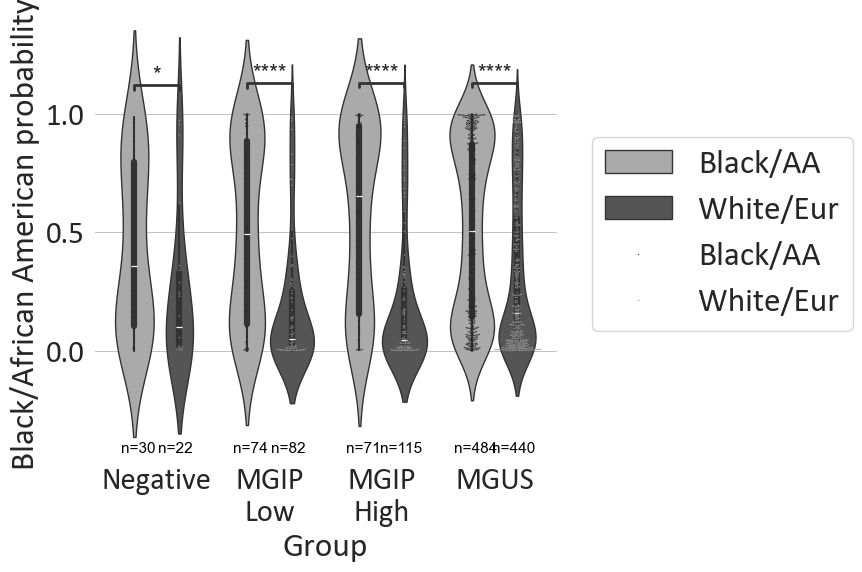

C:\Users\flori\AppData\Local\Temp\ipykernel_30316\3945561324.py:226: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#999999'` for the same effect.

  sns.swarmplot(data=data, x=x, y=y, hue=hue,
C:\Users\flori\AppData\Local\Temp\ipykernel_30316\3945561324.py:271: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks, fontdict=ticks_font_params)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MGIP
Low_Black/AA vs. MGIP
Low_White/Eur: Mann-Whitney-Wilcoxon test two-sided, P_val:1.543e-07 U_stat=4.513e+03
Negative_Black/AA vs. Negative_White/Eur: Mann-Whitney-Wilcoxon test two-sided, P_val:1.360e-01 U_stat=4.110e+02
MGIP
High_Black/AA vs. MGIP
High_White/Eur: Mann-Whitney-Wilcoxon test two-sided, P_val:2.456e-12 U_stat=6.582e+03
MGUS_Black/AA vs. MGUS_White/Eur: Mann-Whitney-Wilcoxon test two-sided, P_val:2.249e-25 U_stat=1.487e+05


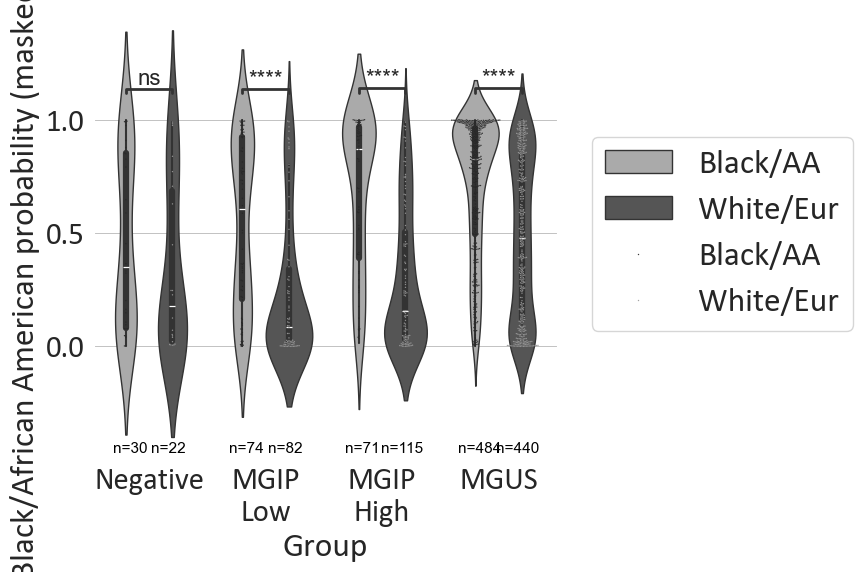

In [17]:
boxplot_predicted_quantative_versus_gt_class(balanced_df=balanced_df, PREDS_COLNAME=PREDS_COLNAME,
                                             peak_method_ticks=peak_method_ticks,
                                             ANALYSIS_BY=ANALYSIS_BY, groups_ordered_values=groups_ordered_values,
                                             placeholder_dict=placeholder_dict,
                                             ANALYSIS_BY_PLACEHOLDER=ANALYSIS_BY_PLACEHOLDER,
                                             groups_ordered_values_placeholder=groups_ordered_values_placeholder,
                                             peak_method_2_label=peak_method_2_label,
                                             separate_mgs_into_hue=True,
                                             swarmsize=1)

Similarily, we can plot the score predicted for patients regardless of their monoclonal gammopathy status

C:\Users\flori\AppData\Local\Temp\ipykernel_30316\3945561324.py:219: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=data, x=x, y=y, hue=hue,
C:\Users\flori\AppData\Local\Temp\ipykernel_30316\3945561324.py:271: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks, fontdict=ticks_font_params)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Black/AA vs. White/Eur: Mann-Whitney-Wilcoxon test two-sided, P_val:8.076e-37 U_stat=3.047e+05


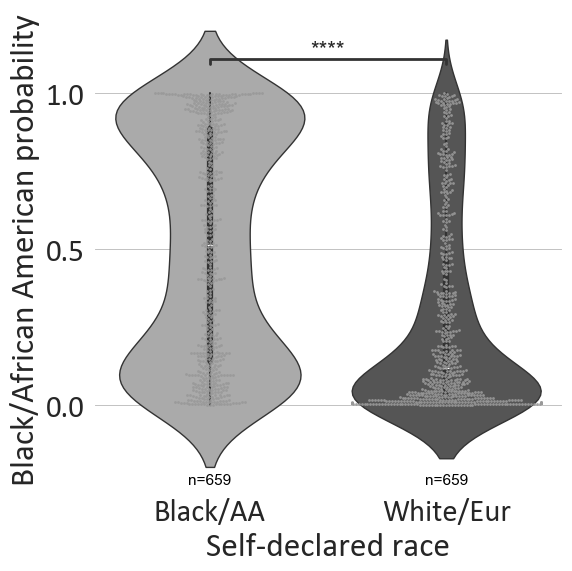

C:\Users\flori\AppData\Local\Temp\ipykernel_30316\3945561324.py:219: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=data, x=x, y=y, hue=hue,
C:\Users\flori\AppData\Local\Temp\ipykernel_30316\3945561324.py:271: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks, fontdict=ticks_font_params)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Black/AA vs. White/Eur: Mann-Whitney-Wilcoxon test two-sided, P_val:3.150e-42 U_stat=3.112e+05


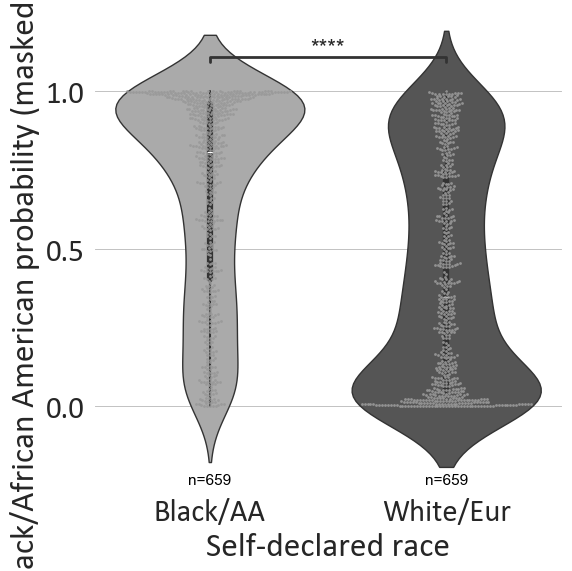

In [18]:
boxplot_predicted_quantative_versus_gt_class(balanced_df=balanced_df, PREDS_COLNAME=PREDS_COLNAME,
                                             peak_method_ticks=peak_method_ticks,
                                             ANALYSIS_BY=ANALYSIS_BY, groups_ordered_values=groups_ordered_values,
                                             placeholder_dict=placeholder_dict,
                                             ANALYSIS_BY_PLACEHOLDER=ANALYSIS_BY_PLACEHOLDER,
                                             groups_ordered_values_placeholder=groups_ordered_values_placeholder,
                                             peak_method_2_label=peak_method_2_label,
                                             separate_mgs_into_hue=False,
                                             swarmsize=2)

Then, using the balanced dataset, we can check the ROC AUC of black probability predicted by the model according to ground truth race

C:\Users\flori\AppData\Local\Temp\ipykernel_30316\3945561324.py:396: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks, fontdict=ticks_font_params)
C:\Users\flori\AppData\Local\Temp\ipykernel_30316\3945561324.py:397: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(yticks, fontdict=ticks_font_params)


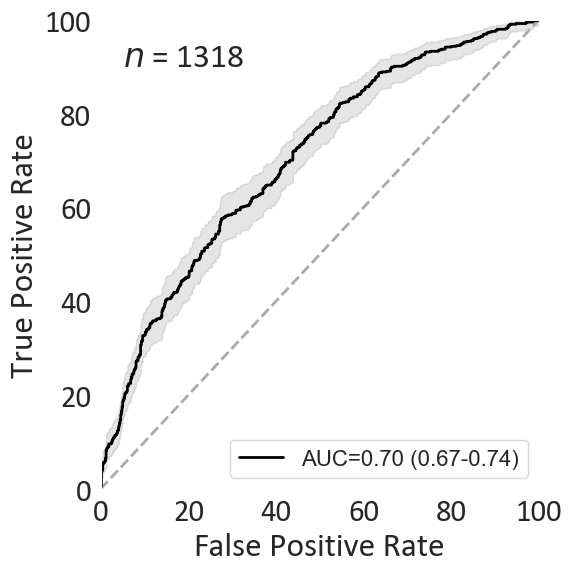

In [19]:
peak_method = PREDS_COLNAME
plt.figure(figsize=(pp_size, pp_size))
plot_roc(y=balanced_df[TRUES_COLNAME], y_=balanced_df[peak_method], display_n=True, confidence_level=.99)
plt.show()

Same, when peaks are masked from the model's input

C:\Users\flori\AppData\Local\Temp\ipykernel_30316\3945561324.py:396: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks, fontdict=ticks_font_params)
C:\Users\flori\AppData\Local\Temp\ipykernel_30316\3945561324.py:397: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(yticks, fontdict=ticks_font_params)


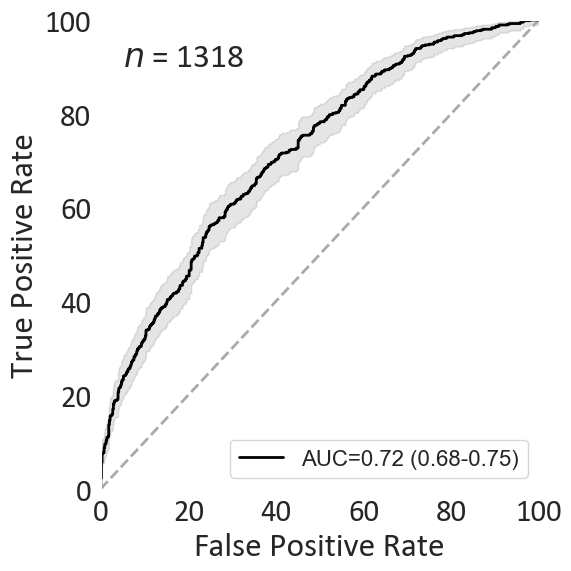

In [20]:
peak_method = PREDS_COLNAME + " (peaks dropped out)"
plt.figure(figsize=(pp_size, pp_size))
plot_roc(y=balanced_df[TRUES_COLNAME], y_=balanced_df[peak_method], display_n=True, confidence_level=.99)
plt.show()

Then separate patients according to their MG status

This is **Supplementary Figure S8**

C:\Users\flori\AppData\Local\Temp\ipykernel_30316\3945561324.py:396: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks, fontdict=ticks_font_params)
C:\Users\flori\AppData\Local\Temp\ipykernel_30316\3945561324.py:397: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(yticks, fontdict=ticks_font_params)
C:\Users\flori\AppData\Local\Temp\ipykernel_30316\3945561324.py:396: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks, fontdict=ticks_font_params)
C:\Users\flori\AppData\Local\Temp\ipykernel_30316\3945561324.py:397: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(yticks, fontdict=tic

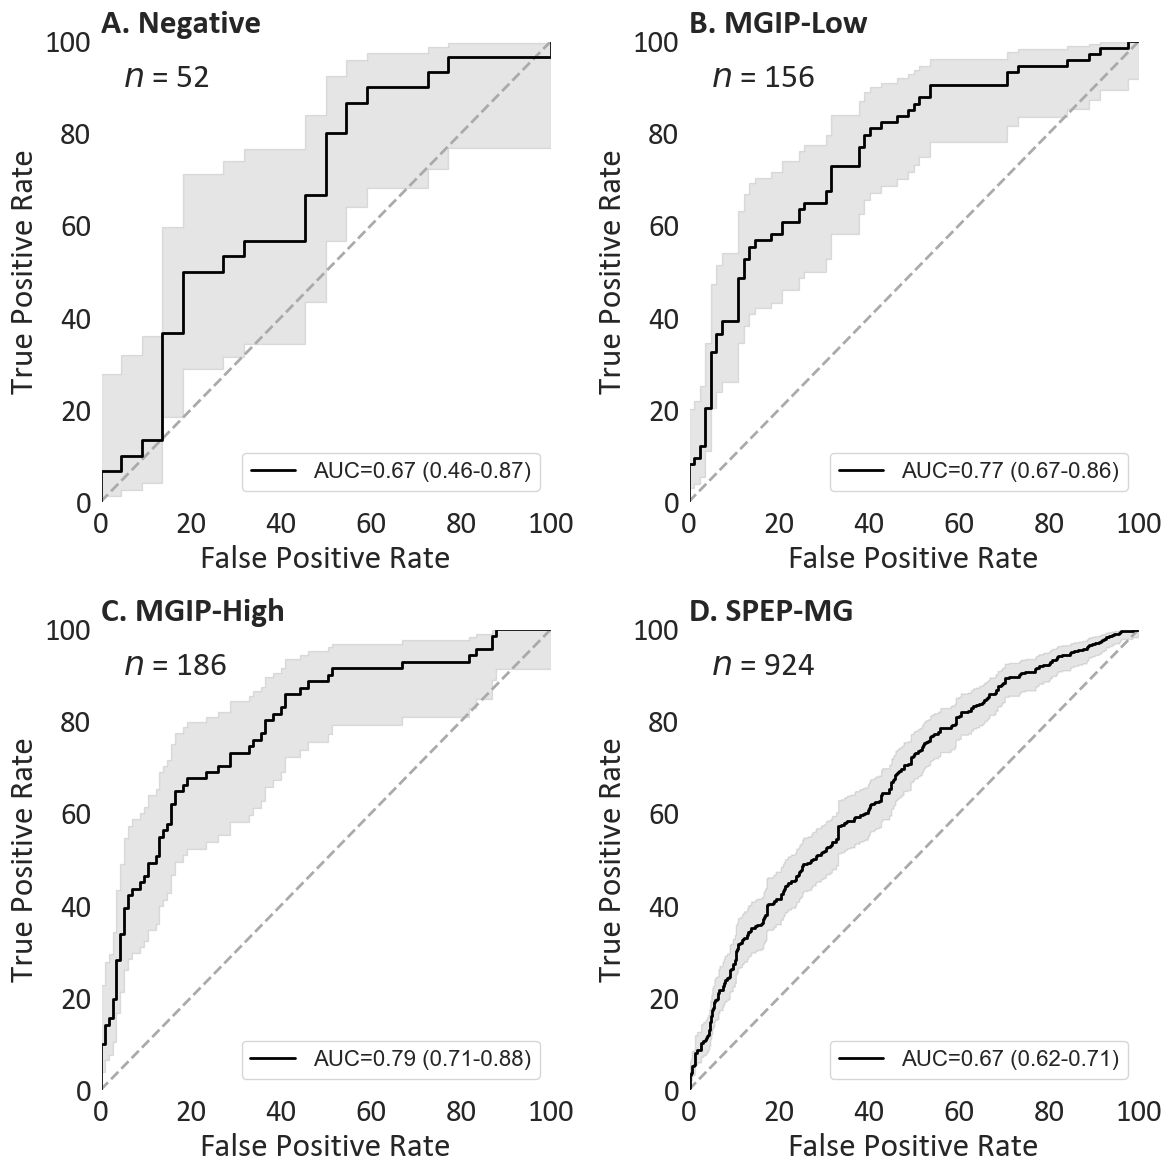

In [21]:
peak_method = PREDS_COLNAME
plt.figure(figsize=(pp_size * 2, pp_size * 2))
for k, group in enumerate(["Negative", "MGIP-Low", "MGIP-High", "MGUS"]):
    plt.subplot(2, 2, k + 1)
    if (balanced_df.Group == group).any():
        plot_roc(y=balanced_df[balanced_df.Group == group][TRUES_COLNAME],
                 y_=balanced_df[balanced_df.Group == group][peak_method],
                 suptitle="ABCD"[k] + ". " + ("SPEP-MG" if group == "MGUS" else group),
                 display_n=True, confidence_level=.99)
plt.show()

Same, using the spectra with masked peaks

C:\Users\flori\AppData\Local\Temp\ipykernel_30316\3945561324.py:396: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks, fontdict=ticks_font_params)
C:\Users\flori\AppData\Local\Temp\ipykernel_30316\3945561324.py:397: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(yticks, fontdict=ticks_font_params)
C:\Users\flori\AppData\Local\Temp\ipykernel_30316\3945561324.py:396: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks, fontdict=ticks_font_params)
C:\Users\flori\AppData\Local\Temp\ipykernel_30316\3945561324.py:397: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(yticks, fontdict=tic

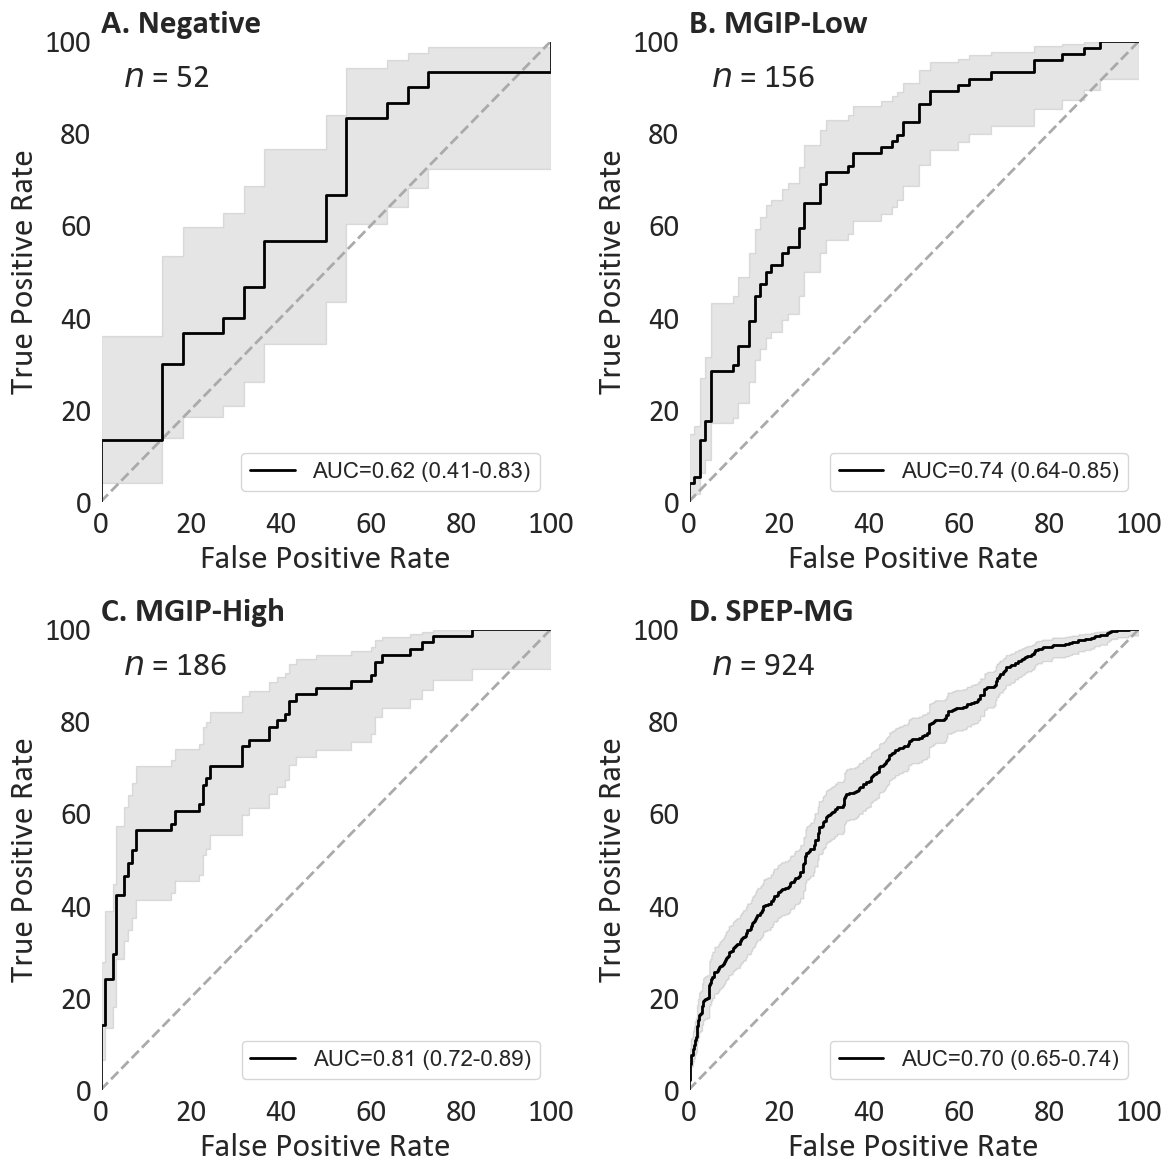

In [22]:
peak_method = PREDS_COLNAME + " (peaks dropped out)"
plt.figure(figsize=(pp_size * 2, pp_size * 2))
for k, group in enumerate(["Negative", "MGIP-Low", "MGIP-High", "MGUS"]):
    plt.subplot(2, 2, k + 1)
    if (balanced_df.Group == group).any():
        plot_roc(y=balanced_df[balanced_df.Group == group][TRUES_COLNAME],
                 y_=balanced_df[balanced_df.Group == group][peak_method],
                 suptitle="ABCD"[k] + ". " + ("SPEP-MG" if group == "MGUS" else group),
                 display_n=True, confidence_level=.99)
plt.show()

# Feature exploration

Early routine declarations follow what is detailed in the BiAge jupyter notebook

In [23]:
from scipy.ndimage import gaussian_filter
from scipy.signal import find_peaks, peak_prominences
from pybaselines import Baseline

# default parameters
DEFAULT_GAUSSIANS = ["ll", "lk", "hl", "hk", "c1q"]
DEFAULT_GAUSSIAN_NAMES = [["λ1", "κ1", "λ2", "κ2", "C1q"],
                          ["λ1", "κ1", "λ2", "κ2", "C1q"],
                          ["λ1", "κ1", "λ2", "κ2", "C1q"],
                          ["λ1", "κ1", "λ2", "κ2", "C1q"],
                          ["λ1", "κ1", "λ2", "κ2", "C1q"], ]
DEFAULT_ISOTYPES = "GAMKL"
DEFAULT_HARDCODED_PARAMS = {'ll_mz': 11414, 'll_width': 150.,
                            'lk_mz': 11701, 'lk_width': 150.,
                            'hl_mz': 11752, 'hl_width': 200.,
                            'hk_mz': 12060, 'hk_width': 200.,
                            'c1q_mz': 12018, 'c1q_width': 15.,
                            }
DEFAULT_INIT_GLOBAL_PARAMS = {
    "ll_mz_mod": 0, "lk_mz_mod": 0, "hl_mz_mod": 0, "hk_mz_mod": 0, "c1q_mz_mod": 0,
    "iso0_mz_mod": 0, "iso1_mz_mod": 0, "iso2_mz_mod": 0, "iso3_mz_mod": 0, "iso4_mz_mod": 0,
    "ll_width_mod": 0, "lk_width_mod": 0, "hl_width_mod": 0, "hk_width_mod": 0, "c1q_width_mod": 0,
    "iso0_width_mod": 0, "iso1_width_mod": 0, "iso2_width_mod": 0, "iso3_width_mod": 0, "iso4_width_mod": 0,
    "ll_iso0_weight": 0.6, "lk_iso0_weight": 0.9, "hl_iso0_weight": 0.05, "hk_iso0_weight": 0.15, "c1q_iso0_weight": 0.005,
    "ll_iso1_weight": 0.85, "lk_iso1_weight": 0.85, "hl_iso1_weight": 0.05, "hk_iso1_weight": 0.15, "c1q_iso1_weight": 0.005,
    "ll_iso2_weight": 0.77, "lk_iso2_weight": 0.9, "hl_iso2_weight": 0.02, "hk_iso2_weight": 0.4, "c1q_iso2_weight": 0.005,
    "ll_iso3_weight": 0.01, "lk_iso3_weight": 0.9, "hl_iso3_weight": 0.001, "hk_iso3_weight": 0.15, "c1q_iso3_weight": 0.005,
    "ll_iso4_weight": 0.95, "lk_iso4_weight": 0.01, "hl_iso4_weight": 0.06, "hk_iso4_weight": 0.001, "c1q_iso4_weight": 0.1,
}
INDIVIDUAL_GAUSSIAN_MZ_MOD_MAX = 5  # we won't tolerate much offset for any specific gaussian (either all gaussians are shifted or none, basically)
INDIVIDUAL_ISOTYPE_MZ_MOD_MAX = 50  # we tolerate a specific track to be offset to some extent
INDIVIDUAL_GAUSSIAN_WIDTH_MOD_MAX = 5  # we won't tolerate much offset for any specific gaussian (either all gaussians are narrower or none, basically)
INDIVIDUAL_ISOTYPE_WIDTH_MOD_MAX = 50  # we tolerate a specific track to be offset to some extent: in particular we noticed that IgMs tend to be narrower
DEFAULT_GLOBAL_PARAMS_LBOUNDS = {
    "ll_mz_mod": -INDIVIDUAL_GAUSSIAN_MZ_MOD_MAX, "lk_mz_mod": -INDIVIDUAL_GAUSSIAN_MZ_MOD_MAX, "hl_mz_mod": -INDIVIDUAL_GAUSSIAN_MZ_MOD_MAX,
    "hk_mz_mod": -INDIVIDUAL_GAUSSIAN_MZ_MOD_MAX, "c1q_mz_mod": -INDIVIDUAL_GAUSSIAN_MZ_MOD_MAX,
    "iso0_mz_mod": -INDIVIDUAL_ISOTYPE_MZ_MOD_MAX, "iso1_mz_mod": -INDIVIDUAL_ISOTYPE_MZ_MOD_MAX, "iso2_mz_mod": -INDIVIDUAL_ISOTYPE_MZ_MOD_MAX,
    "iso3_mz_mod": -INDIVIDUAL_ISOTYPE_MZ_MOD_MAX, "iso4_mz_mod": -INDIVIDUAL_ISOTYPE_MZ_MOD_MAX,
    "ll_width_mod": -INDIVIDUAL_GAUSSIAN_WIDTH_MOD_MAX, "lk_width_mod": -INDIVIDUAL_GAUSSIAN_WIDTH_MOD_MAX,
    "hl_width_mod": -INDIVIDUAL_GAUSSIAN_WIDTH_MOD_MAX, "hk_width_mod": -INDIVIDUAL_GAUSSIAN_WIDTH_MOD_MAX, "c1q_width_mod": -5,
    "iso0_width_mod": -INDIVIDUAL_ISOTYPE_WIDTH_MOD_MAX, "iso1_width_mod": -INDIVIDUAL_ISOTYPE_WIDTH_MOD_MAX,
    "iso2_width_mod": -INDIVIDUAL_ISOTYPE_WIDTH_MOD_MAX, "iso3_width_mod": -INDIVIDUAL_ISOTYPE_WIDTH_MOD_MAX,
    "iso4_width_mod": -INDIVIDUAL_ISOTYPE_WIDTH_MOD_MAX,
    "ll_iso0_weight": 0., "lk_iso0_weight": 0., "hl_iso0_weight": 0., "hk_iso0_weight": 0., "c1q_iso0_weight": 0.,
    "ll_iso1_weight": 0., "lk_iso1_weight": 0., "hl_iso1_weight": 0., "hk_iso1_weight": 0., "c1q_iso1_weight": 0.,
    "ll_iso2_weight": 0., "lk_iso2_weight": 0., "hl_iso2_weight": 0., "hk_iso2_weight": 0., "c1q_iso2_weight": 0.,
    "ll_iso3_weight": 0., "lk_iso3_weight": 0., "hl_iso3_weight": 0., "hk_iso3_weight": 0., "c1q_iso3_weight": 0.,
    "ll_iso4_weight": 0., "lk_iso4_weight": 0., "hl_iso4_weight": 0., "hk_iso4_weight": 0., "c1q_iso4_weight": 0.,
}
DEFAULT_GLOBAL_PARAMS_UBOUNDS = {
    "ll_mz_mod": INDIVIDUAL_GAUSSIAN_MZ_MOD_MAX, "lk_mz_mod": INDIVIDUAL_GAUSSIAN_MZ_MOD_MAX, "hl_mz_mod": INDIVIDUAL_GAUSSIAN_MZ_MOD_MAX,
    "hk_mz_mod": INDIVIDUAL_GAUSSIAN_MZ_MOD_MAX, "c1q_mz_mod": INDIVIDUAL_GAUSSIAN_MZ_MOD_MAX,
    "iso0_mz_mod": INDIVIDUAL_ISOTYPE_MZ_MOD_MAX, "iso1_mz_mod": INDIVIDUAL_ISOTYPE_MZ_MOD_MAX, "iso2_mz_mod": INDIVIDUAL_ISOTYPE_MZ_MOD_MAX,
    "iso3_mz_mod": INDIVIDUAL_ISOTYPE_MZ_MOD_MAX, "iso4_mz_mod": INDIVIDUAL_ISOTYPE_MZ_MOD_MAX,
    "ll_width_mod": INDIVIDUAL_GAUSSIAN_WIDTH_MOD_MAX, "lk_width_mod": INDIVIDUAL_GAUSSIAN_WIDTH_MOD_MAX, "hl_width_mod": INDIVIDUAL_GAUSSIAN_WIDTH_MOD_MAX,
    "hk_width_mod": INDIVIDUAL_GAUSSIAN_WIDTH_MOD_MAX, "c1q_width_mod": 5,
    "iso0_width_mod": INDIVIDUAL_ISOTYPE_WIDTH_MOD_MAX, "iso1_width_mod": INDIVIDUAL_ISOTYPE_WIDTH_MOD_MAX,
    "iso2_width_mod": INDIVIDUAL_ISOTYPE_WIDTH_MOD_MAX, "iso3_width_mod": INDIVIDUAL_ISOTYPE_WIDTH_MOD_MAX,
    "iso4_width_mod": INDIVIDUAL_ISOTYPE_WIDTH_MOD_MAX,
    "ll_iso0_weight": 1., "lk_iso0_weight": 1., "hl_iso0_weight": .1, "hk_iso0_weight": .5, "c1q_iso0_weight": 0.01,
    "ll_iso1_weight": 1., "lk_iso1_weight": 1., "hl_iso1_weight": .1, "hk_iso1_weight": .5, "c1q_iso1_weight": 0.01,
    "ll_iso2_weight": 1., "lk_iso2_weight": 1., "hl_iso2_weight": .1, "hk_iso2_weight": .5, "c1q_iso2_weight": 0.01,
    "ll_iso3_weight": .1, "lk_iso3_weight": 1., "hl_iso3_weight": .01, "hk_iso3_weight": .5, "c1q_iso3_weight": 0.01,
    "ll_iso4_weight": 1., "lk_iso4_weight": .1, "hl_iso4_weight": 2., "hk_iso4_weight": .01, "c1q_iso4_weight": 0.15,
}
DEFAULT_GLOBAL_PARAMS_BOUNDS = (DEFAULT_GLOBAL_PARAMS_LBOUNDS, DEFAULT_GLOBAL_PARAMS_UBOUNDS)
P_KEYS = ['ll_mz_mod', 'lk_mz_mod', 'hl_mz_mod', 'hk_mz_mod', 'c1q_mz_mod', 'iso0_mz_mod', 'iso1_mz_mod', 'iso2_mz_mod', 'iso3_mz_mod', 'iso4_mz_mod',
          'll_width_mod', 'lk_width_mod', 'hl_width_mod', 'hk_width_mod', 'c1q_width_mod', 'iso0_width_mod', 'iso1_width_mod', 'iso2_width_mod',
          'iso3_width_mod', 'iso4_width_mod', 'll_iso0_weight', 'lk_iso0_weight', 'hl_iso0_weight', 'hk_iso0_weight', 'c1q_iso0_weight', 'll_iso1_weight',
          'lk_iso1_weight', 'hl_iso1_weight', 'hk_iso1_weight', 'c1q_iso1_weight', 'll_iso2_weight', 'lk_iso2_weight', 'hl_iso2_weight', 'hk_iso2_weight',
          'c1q_iso2_weight', 'll_iso3_weight', 'lk_iso3_weight', 'hl_iso3_weight', 'hk_iso3_weight', 'c1q_iso3_weight', 'll_iso4_weight', 'lk_iso4_weight',
          'hl_iso4_weight', 'hk_iso4_weight', 'c1q_iso4_weight']
# default colors
# DEFAULT_LKCOLOR = "#D1E9F6"  # light blue
# DEFAULT_HKCOLOR = "#55679C"  # dark blue
# DEFAULT_LLCOLOR = "#D5ED9F"  # light green
# DEFAULT_HLCOLOR = "#0D7C66"  # dark green
DEFAULT_LLCOLOR = "#D1E9F6"  # light blue
DEFAULT_HLCOLOR = "#55679C"  # dark blue
DEFAULT_LKCOLOR = "#FFCD90"  # light orange
DEFAULT_HKCOLOR = "#FF8D21"  # dark orange
DEFAULT_C1QCOLOR = "#0D7C66"  # dark green

DEFAULT_PARAM_COLORS = [[DEFAULT_LLCOLOR, DEFAULT_LKCOLOR, DEFAULT_HLCOLOR, DEFAULT_HKCOLOR, DEFAULT_C1QCOLOR],
                        [DEFAULT_LLCOLOR, DEFAULT_LKCOLOR, DEFAULT_HLCOLOR, DEFAULT_HKCOLOR, DEFAULT_C1QCOLOR],
                        [DEFAULT_LLCOLOR, DEFAULT_LKCOLOR, DEFAULT_HLCOLOR, DEFAULT_HKCOLOR, DEFAULT_C1QCOLOR],
                        [DEFAULT_LLCOLOR, DEFAULT_LKCOLOR, DEFAULT_HLCOLOR, DEFAULT_HKCOLOR, DEFAULT_C1QCOLOR],
                        [DEFAULT_LLCOLOR, DEFAULT_LKCOLOR, DEFAULT_HLCOLOR, DEFAULT_HKCOLOR, DEFAULT_C1QCOLOR]]

def load_sample_ms_data_for_deconvolution(dataset_path: str, match_id: str, remove_background_noise: bool = True, normalization: str = ["auc", "01"][1]):
    """
    Same as python.pyms_assets.dl_ms_data_manager.load_sample_ms_data, but with an extra step of cleaning/normalizing the sample

    :param dataset_path: str, the path to the MS dataset
    :param match_id: str, the Match ID of the sample
    :return: np.array, the MS raw data for this sample
    """

    x = load_sample_ms_data(dataset_path, match_id)
    if remove_background_noise:
        x[1, ...] = x[1, ...] - x[1, ...].min(axis=1, keepdims=True)
    if normalization == "auc":
        x[1, ...] = x[1, ...] / (np.trapz(x[1, ...], x[0, ...])[:, None])
    elif normalization == "01":
        x[1, ...] = x[1, ...] / x[1, ...].max(axis=1, keepdims=True)
    else:
        assert False, f"Unknown {normalization=}"
    return x


def digitize_msdata(x: np.array, isotype: int):
    """
    Prepare MS data for modelling
    # basically for one isotype (G, A, M, K, L) we take the list of m/z and corresponding counts
    # and turn that into a pd.DataFrame with two columns: m/z and count

    :param x: np.array of shape (2,5,n) with n a variable length for the MS trace
    :param isotype: int, the index of the isotype we want to select
    :return: pd.DataFrame
    """
    ms_digitized_data = pd.DataFrame(np.stack([x[0, isotype, :], x[1, isotype, :]], axis=1))
    return ms_digitized_data


def global_gaussian_func_maker_v2(harcoded_params: dict, p_keys: list, n_isotypes: int, gaussians: list):
    """
    reconstructs (models) the count based on m/z and parameters of the underlying gaussians

    :param harcoded_params: harcoded params, i.e. parameters that cannot be changed (such as m/z center of gaussians)
    :param p_keys: keys used for converting the list of parameters to a dict of parameters
    :param n_isotypes: number of isotypes, usually 5
    :param gaussians: number and names of gaussians, usually ["ll", "lk", "hl", "hk", "c1q"]
    :return:
    """

    # create a new function modifying the hardcoded params by the p0 parameters
    def temp_global_gaussian_func(x_raw: np.array, *p):
        named_p = dict(zip(p_keys, p))

        xy_size = len(x_raw) // n_isotypes
        y_pred = np.zeros_like(x_raw)
        for iso in range(n_isotypes):
            for gaussn in gaussians:
                ctr = harcoded_params[f"{gaussn}_mz"] + named_p[f"{gaussn}_mz_mod"] + named_p[f"iso{iso}_mz_mod"]
                width = harcoded_params[gaussn + "_width"] + named_p[f"{gaussn}_width_mod"] + named_p[f"iso{iso}_width_mod"]
                amp = named_p[f"{gaussn}_iso{iso}_weight"]

                y_pred[(iso * xy_size):((iso + 1) * xy_size)] += amp * np.exp(
                    -((x_raw[(iso * xy_size):((iso + 1) * xy_size)] - ctr) / width) ** 2)
        return y_pred

    return temp_global_gaussian_func


def optimize_global_params(x: np.array, p_keys: list, gaussians: list, n_isotypes: int, harcoded_params: dict, init_global_params: dict,
                           global_params_bounds: tuple):
    """
    optimize initial gaussian parameters to make them fit a y=f(x) count=f(m/z) full ms spectra; does optimization for all tracks (isotypes) at the same time

    :param x: array of ms data
    :param p_keys: names of the gaussian parameters used in init_global_params
    :param gaussians: number and names of gaussians
    :param n_isotypes: number of isotypes, usually 5
    :param harcoded_params: harcoded parameters for the gaussians, such as m/z center of the gaussians
    :param init_global_params: initial (unoptimized) gaussian parameters
    :param global_params_bounds: boundaries for the gaussian parameters (min anx max)
    :return:
    """

    from scipy.optimize import curve_fit

    # convert ms digitized data (pd.DataFrame) to np.arrays
    x_raw = np.concatenate([x[0, iso, :] for iso in range(n_isotypes)])
    y_raw = np.concatenate([x[1, iso, :] for iso in range(n_isotypes)])

    p0 = [init_global_params[k] for k in p_keys]
    p_bounds = ([global_params_bounds[0][k] for k in p_keys],
                [global_params_bounds[1][k] for k in p_keys])

    # returns the fitting parameters, accepts the function,data and init_para
    # noinspection PyTupleAssignmentBalance
    popt_gauss, pcov_gauss = curve_fit(
        f=global_gaussian_func_maker_v2(harcoded_params=harcoded_params, p_keys=p_keys, n_isotypes=n_isotypes, gaussians=gaussians),
        xdata=x_raw, ydata=y_raw, p0=p0, bounds=p_bounds, maxfev=50000)

    # convert back to the params format
    optim_global_params = dict(zip(p_keys, popt_gauss))

    return optim_global_params


def global_params_to_params(harcoded_params: dict, optim_global_params: dict, n_isotypes: int, gaussians: list):
    """
    convert dict in the format "global_params" to "params" (useful for plotting modelling results)

    :param harcoded_params: see previous functions
    :param optim_global_params: init_params after optimization by a previous function
    :param n_isotypes: 5
    :param gaussians: number and names of the gaussians
    :return:
    """
    # convert new global format to old format by isotype
    convert_params = []
    for iso in range(n_isotypes):
        convert_iso_params = []
        for gaussi, gaussn in enumerate(gaussians):
            convert_iso_params.append({"weight": optim_global_params[f"{gaussn}_iso{iso}_weight"],
                                       "mean": harcoded_params[f"{gaussn}_mz"] + optim_global_params[f"{gaussn}_mz_mod"] + optim_global_params[
                                           f"iso{iso}_mz_mod"],
                                       "std": harcoded_params[f"{gaussn}_width"] + optim_global_params[f"{gaussn}_width_mod"] + optim_global_params[
                                           f"iso{iso}_width_mod"]})
        convert_params.append(convert_iso_params)
    return convert_params


def deconvolute_gaussians_v2(dataset_path: str, match_id: str, p_keys: list, gaussians: list, n_isotypes: int,
                             harcoded_params: dict, init_global_params: dict, global_params_bounds: tuple,
                             return_rmse: bool = False):
    """
    Deconvolute the gaussians of a MS sample

    :param dataset_path: str, the path to the MS dataset
    :param match_id: str, the Match ID of the sample
    :param gaussians: number and names of gaussians, usually ["ll", "lk", "hl", "hk", "c1q"]
    :param n_isotypes: number of isotypes, usually 5
    :param harcoded_params: harcoded params, i.e. parameters that cannot be changed (such as m/z center of gaussians)
    :param init_global_params: initial (unoptimized) gaussian parameters
    :param global_params_bounds: boundaries for the gaussian parameters (min anx max)
    :param return_rmse: bool, whether to also return rmse between original and reconstructed data
    :return:
    """

    x = load_sample_ms_data_for_deconvolution(dataset_path, match_id)

    ms_digitized_data_buffer = [digitize_msdata(x=x, isotype=isotype) for isotype in range(n_isotypes)]

    optim_global_params = optimize_global_params(x=x,
                                                 p_keys=p_keys,
                                                 gaussians=gaussians,
                                                 n_isotypes=n_isotypes,
                                                 harcoded_params=harcoded_params,
                                                 init_global_params=init_global_params,
                                                 global_params_bounds=global_params_bounds)

    optim_params_buffer = global_params_to_params(harcoded_params=harcoded_params, optim_global_params=optim_global_params,
                                                  n_isotypes=n_isotypes, gaussians=gaussians)

    if return_rmse:
        # QC (rmse)
        ggmxs = [model_trace_from_gaussians(ms_digitized_data.iloc[:, 0], optim_params).values for ms_digitized_data, optim_params in
                 zip(ms_digitized_data_buffer, optim_params_buffer)]
        ggmxs = np.stack(ggmxs, axis=0)
        groundtruths = np.stack([ms_digitized_data.iloc[:, 1].values for ms_digitized_data in ms_digitized_data_buffer], axis=0)
        rmse = np.sum(np.power(groundtruths - ggmxs, 2))
        return ms_digitized_data_buffer, optim_params_buffer, rmse

    return ms_digitized_data_buffer, optim_params_buffer


def gaussian_func(x: np.array, *p):
    """
    Generate a trace from the list of m/z and the mean, std and weight of one/multiple gaussian distributions

    :param x: np.array, the list of m/z of the MS trace
    :param p: the list of parameters of the gaussians; length must be a multiple of 3
    :return: np.array, the y matching the x, i.e. the modelled count list (MS trace) according to the gaussian distributions parameters passed to the function
    """
    y = np.zeros_like(x)
    for i in range(0, len(p), 3):
        amp = p[i]  # amplitude
        ctr = p[i + 1]  # peak location
        width = p[i + 2]  # standard deviation
        y += amp * np.exp(-((x - ctr) / width) ** 2)
    return y


def model_trace_from_gaussians(x: np.array, params: list):
    """
    Generate a trace from the list of m/z and the mean, std and weight of one/multiple gaussian distributions

    :param x: np.array, the list of m/z of the MS trace
    :param params: a list of gaussian parameters, shape [{"weight": weight1, "mena": mean1, "std": std1}, ..., {"weight": weightN, "mena": meanN, "std": stdN}] with N gaussians
    :return: np.array, the y matching the x, i.e. the modelled count list (MS trace) according to the gaussian distributions parameters passed to the function
    """
    p = [v for param in params for v in [param["weight"], param["mean"], param["std"]]]
    return gaussian_func(x, *p)

def ipsa_baseline(x_track: np.array, half_window: int = 40, tol: float = 1e-3) -> np.array:
    """
    Smoothes an MS spectra using the IPSA method (see pybaselines package)
    Used primarily to compute a "baseline", i.e. a smooth model of the trace without peaks, used to both detect and quantify peaks
    See Mass Fix article for details about this detection/quantification method
    May be chosen over ria, Mass Fix article states it uses a method close to the ipsa/ria algorithms from the pybaselines package

    :param x_track: the MS spectra np array of the isotype, i.e. of shape 2xN
    :param half_window: the half_window parameter used by the pybaselines' package "ipsa" function. Optimal value found empirically was 40.
    :param tol: the tol parameter used by the pybaselines' package "ipsa" function. Optimal value found empirically was 1e-3.
    :return: the smoothed spectra, a numpy.array of shape 2xN
    """
    new_x_track = x_track.copy()
    baseline_fitter = Baseline(x_track[0, :], check_finite=False)
    synthetic_distrib = baseline_fitter.ipsa(x_track[1, :], half_window=half_window, tol=tol)[0]
    new_x_track[1, :] = synthetic_distrib
    return new_x_track


def peak_detection_v3(dataset_path: str, match_id: str, pre_smooth_sigma: int = 3, residuals_gaussian_sigma: int = 10, peak_height_threshold: float = .01):

    # get a random sample (negative, so we have some peaks to detect)
    # load the sample data
    x = load_sample_ms_data_for_deconvolution(dataset_path=dataset_path,
                                              match_id=match_id,
                                              remove_background_noise=True,
                                              normalization="01")

    if pre_smooth_sigma > 0:
        x[1, ...] = gaussian_filter(x[1, ...], sigma=pre_smooth_sigma, axes=1)

    # model the raw ms trace using ipsa
    x_ipsa = np.stack([ipsa_baseline(x[:, iso, :])[1] for iso in range(5)], axis=0)

    residuals = x[1] - x_ipsa
    smoothed_residuals = gaussian_filter(residuals, sigma=residuals_gaussian_sigma, axes=1)

    peaks_data = [find_peaks(smoothed_residuals[iso], height=peak_height_threshold) for iso in range(5)]

    # remove any peaks in the lambda region that would be C1q
    retain_lambda_peaks = []
    found_lambda_peaks_to_remove = False
    for lambda_peak_i, lambda_peak_pos in enumerate(peaks_data[4][0]):
        if x[0, 4, lambda_peak_pos] < 12000:
            retain_lambda_peaks.append(lambda_peak_i)
        else:
            found_lambda_peaks_to_remove = True
    if found_lambda_peaks_to_remove:
        peaks_data[4] = (peaks_data[4][0][retain_lambda_peaks],
                         {"peak_heights": peaks_data[4][1]["peak_heights"][retain_lambda_peaks]})

    # we could optionally get the peaks prominence
    for iso in range(5):
        peaks_data[iso][1]["prominences"] = peak_prominences(smoothed_residuals[iso], peaks=peaks_data[iso][0])[0]

    trace_peaks_analysis = {"x": x, "x_ipsa": x_ipsa, "residuals": residuals, "smoothed_residuals": smoothed_residuals, "peaks_data": peaks_data}
    return trace_peaks_analysis

def decompose_trace_features(match_id: str, rmse_threshold: float = 10., peak_detection_height_thresholds: list = (.01, .03)):

    trace_features = {"ANON_ID": match_id}

    ms_digitized_data_buffer, optim_params_buffer, rmse = deconvolute_gaussians_v2(dataset_path=dataset_dir,
                                                                                   match_id=match_id,
                                                                                   p_keys=P_KEYS,
                                                                                   gaussians=DEFAULT_GAUSSIANS,
                                                                                   n_isotypes=len(DEFAULT_ISOTYPES),
                                                                                   harcoded_params=DEFAULT_HARDCODED_PARAMS,
                                                                                   init_global_params=DEFAULT_INIT_GLOBAL_PARAMS,
                                                                                   global_params_bounds=DEFAULT_GLOBAL_PARAMS_BOUNDS,
                                                                                   return_rmse=True)

    # reconstruct the x
    x = np.stack([np.stack([ms.iloc[:, 0].values, ms.iloc[:, 1].values]) for ms in ms_digitized_data_buffer], axis=1)

    if rmse > rmse_threshold:
        print(f"Reconstruction error too high! {rmse=} > {rmse_threshold=}")

    trace_features["rmse"] = rmse

    # extract weight and AUC
    for isotype, isotype_n in enumerate(DEFAULT_ISOTYPES):
        isotype_name = f"Ig{isotype_n}" if isotype < 3 else "Kappa" if isotype == 3 else "Lambda" if isotype == 4 else "?"
        ms_digitized_data = ms_digitized_data_buffer[isotype]
        optim_params = optim_params_buffer[isotype]
        ggmx = np.zeros_like(ms_digitized_data.iloc[:, 0])
        weights = []
        trapzs = []
        for i, param in enumerate(optim_params):
            gmx = model_trace_from_gaussians(ms_digitized_data.iloc[:, 0], [param])
            ggmx += gmx
            weights.append(param["weight"])
            trapzs.append(np.trapz(gmx))
        # to %
        weights = np.array(weights)
        trapzs = np.array(trapzs)
        weighted_weights = weights / np.sum(weights)
        weighted_trapzs = trapzs / np.trapz(ggmx)
        # weighted_trapzs = weighted_trapzs / np.sum(weighted_trapzs)
        # save
        trace_features = {**trace_features,
                          **dict(zip([f"{isotype_name} {g} weight" for g in DEFAULT_GAUSSIAN_NAMES[isotype]], weights))}
        trace_features = {**trace_features,
                          **dict(zip([f"{isotype_name} {g} weight (%)" for g in DEFAULT_GAUSSIAN_NAMES[isotype]],
                                     weighted_weights))}
        trace_features = {**trace_features,
                          **dict(zip([f"{isotype_name} {g} AUC" for g in DEFAULT_GAUSSIAN_NAMES[isotype]], trapzs))}
        trace_features = {**trace_features,
                          **dict(zip([f"{isotype_name} {g} AUC (%)" for g in DEFAULT_GAUSSIAN_NAMES[isotype]],
                                     weighted_trapzs))}

    # IPSA or GAUSSIAN FILTER 10 residuals/noise

    for method in ["IPSA", "GF"]:
        for residual_error_method in ["rmse", "maxnoise", "mednoise", ]:

            x_smooth = None
            if method == "IPSA":
                x_smooth = np.stack([ipsa_baseline(x_track=x[:, i, :]) for i in range(5)], axis=1)
            if method == "GF":
                x_smooth = np.stack([x[0, ...], gaussian_filter(x[1, ...], sigma=10, axes=-1)], axis=0)

            residuals = x[1, ...] - x_smooth[1, ...]

            res_name = "?"
            residual_error = np.array([-1, -1, -1, -1, -1])
            if residual_error_method == "pct_auc":
                # old method => trapz / total trapz
                res_name = "residuals"
                residual_error = np.trapz(residuals, x[0, ...], axis=1) / np.trapz(x[1, ...], x[0, ...], axis=1)
            if residual_error_method == "rmse":
                # new method: rmse
                res_name = "residuals"
                residual_error = np.power(residuals, 2).sum(axis=1)
            if residual_error_method == "maxnoise":
                res_name = "max noise"
                residual_error = np.max(residuals, axis=1)
            if residual_error_method == "mednoise":
                res_name = "noise"
                residual_error = np.median(np.abs(residuals), axis=1)

            residual_error = residual_error.tolist()

            trace_features = {**trace_features,
                              **dict(zip((f"IgG {res_name} ({method})", f"IgA {res_name} ({method})", f"IgM {res_name} ({method})",
                                          f"Kappa {res_name} ({method})", f"Lambda {res_name} ({method})"),
                                         residual_error))}

    # AUTOMATED PEAK DETECTION

    trace_peaks_analysis = peak_detection_v3(dataset_path=dataset_dir, match_id=match_id,
                                             peak_height_threshold=peak_detection_height_thresholds[0])
    peaks_data = trace_peaks_analysis["peaks_data"]

    for isotype, isotype_n in enumerate(DEFAULT_ISOTYPES):
        peak_heights = peaks_data[isotype][1]["peak_heights"]
        for peak_height_threshold in peak_detection_height_thresholds:
            isotype_name = f"Ig{isotype_n}" if isotype < 3 else "Kappa" if isotype == 3 else "Lambda" if isotype == 4 else "?"
            n_peaks_found = np.sum(peak_heights >= peak_height_threshold)
            h_peaks_found = np.sum(peak_heights[peak_heights >= peak_height_threshold])
            trace_features[f"{isotype_name} peaks > {100 * peak_height_threshold:.0f}% count"] = n_peaks_found
            trace_features[f"{isotype_name} peaks > {100 * peak_height_threshold:.0f}% height"] = h_peaks_found

    return trace_features

Then, we will declare the parameters that we will use to select the patients in which we want to explore how humoral race is predicted

In [24]:
# make a subset of full_df, but with some patients per humoral age range
n_per_cat = 50
feature_exploration_ranges = [{"min_target_score": -0.1, "max_target_score": 0.1, "n": n_per_cat},
                              {"min_target_score": 0.9, "max_target_score": 1.0, "n": n_per_cat},
                              ]
target_score_colname = "Black/African American probability"
feature_exploration_mode = "qualitative"
refined_features = True
add_ratio_features = True

Then we can create the dataset from which we will sample those samples

In [25]:
all_ms_data_df = create_full_df(trues_colname=TRUES_COLNAME,
                                preds_colname=PREDS_COLNAME,
                                safetycheck_colname=SAFETYCHECK_COLNAME)

And then we can perform the sampling to have a list of samples according to predicted race

In [26]:
# list the samples included in our features exploration analysis
# basically, we want a homogeneous repartition of young, middle-aged and old
# see above for a complete breakdown of desired ranges
feature_exploration_df = []
for humoral_age_range in feature_exploration_ranges:
    candidates = np.where(
        (all_ms_data_df["Group"] == "Negative") & (all_ms_data_df[target_score_colname] > humoral_age_range["min_target_score"]) & (
                all_ms_data_df[target_score_colname] <= humoral_age_range["max_target_score"]))[0]
    assert len(candidates) >= humoral_age_range["n"], f"Only {len(candidates)=}"
    winners = np.random.RandomState(seed=1).choice(candidates, size=humoral_age_range["n"], replace=False)
    feature_exploration_df.append(all_ms_data_df.iloc[winners])
feature_exploration_df = pd.concat(feature_exploration_df, axis=0)
assert not feature_exploration_df.ANON_ID.duplicated().any()
print(len(feature_exploration_df))  # 100 samples selected

100


Then, we will parse those 100 samples and use our `decompose_trace_features` function to extract their features

In [27]:
# decompose the raw ms data of each selected sample to extract gaussians, noise, etc.
trace_features_analysis_results = []
for match_id in tqdm(feature_exploration_df.ANON_ID):
    trace_features = decompose_trace_features(match_id=match_id, rmse_threshold=10.)
    trace_features_analysis_results.append(trace_features)
trace_features_analysis_df = pd.DataFrame(trace_features_analysis_results)
trace_features_analysis_df.index = feature_exploration_df.index

  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\flori\AppData\Local\Temp\ipykernel_30316\4148732059.py:380: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  trapzs.append(np.trapz(gmx))
C:\Users\flori\AppData\Local\Temp\ipykernel_30316\4148732059.py:385: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  weighted_trapzs = trapzs / np.trapz(ggmx)
 13%|█▎        | 13/100 [00:06<00:46,  1.85it/s]

Reconstruction error too high! rmse=np.float64(34.28899395880467) > rmse_threshold=10.0


100%|██████████| 100/100 [00:59<00:00,  1.67it/s]


We then compute additional features and finally remove temporary features, as described in BiAge

In [28]:
# we'll sum lambda1 + lambda2 and same for kappa, for all features
for iso in "GAM":
    for param in ["weight", "weight (%)", "AUC", "AUC (%)"]:
        trace_features_analysis_df[f"Ig{iso} κ1+κ2 {param}"] = (trace_features_analysis_df[f"Ig{iso} κ1 {param}"] +
                                                                trace_features_analysis_df[f"Ig{iso} κ2 {param}"])
        trace_features_analysis_df[f"Ig{iso} λ1+λ2 {param}"] = (trace_features_analysis_df[f"Ig{iso} λ1 {param}"] +
                                                                trace_features_analysis_df[f"Ig{iso} λ2 {param}"])
# also aggregate peaks
for h_thresh in (1, 3):
    for v_type in ("count", "height"):
        trace_features_analysis_df[f"Total peaks > {h_thresh}% {v_type}"] = trace_features_analysis_df[
            [f"Ig{iso} peaks > {h_thresh}% {v_type}" for iso in "GAM"]].sum(axis=1)
# we'll also sum total residuals
for res_method in ["IPSA", "GF"]:
    trace_features_analysis_df[f"Total residuals ({res_method})"] = trace_features_analysis_df[
        [f"{k} residuals ({res_method})" for k in ["IgG", "IgA", "IgM", "Kappa", "Lambda"]]].max(axis=1)
    trace_features_analysis_df[f"Total max noise ({res_method})"] = trace_features_analysis_df[
        [f"{k} max noise ({res_method})" for k in ["IgG", "IgA", "IgM", "Kappa", "Lambda"]]].max(axis=1)
    trace_features_analysis_df[f"Total noise ({res_method})"] = trace_features_analysis_df[
        [f"{k} noise ({res_method})" for k in ["IgG", "IgA", "IgM", "Kappa", "Lambda"]]].max(axis=1)
# we can also add data about ratios, if "enriched_features"
if add_ratio_features:
    for iso in "GAM":
        for param in ["weight", "weight (%)", "AUC", "AUC (%)"]:
            # kappa/lambda 2/1 ratio
            trace_features_analysis_df[f"Ig{iso} κ2/κ1 {param}"] = (trace_features_analysis_df[f"Ig{iso} κ2 {param}"] /
                                                                    trace_features_analysis_df[f"Ig{iso} κ1 {param}"])
            trace_features_analysis_df[f"Ig{iso} λ2/λ1 {param}"] = (trace_features_analysis_df[f"Ig{iso} λ2 {param}"] /
                                                                    trace_features_analysis_df[f"Ig{iso} λ1 {param}"])
            # total kappa/lambda ratio
            trace_features_analysis_df[f"Ig{iso} κ/λ {param}"] = (trace_features_analysis_df[f"Ig{iso} κ1+κ2 {param}"] /
                                                                  trace_features_analysis_df[f"Ig{iso} λ1+λ2 {param}"])
            # trace_features_analysis_df[f"Ig{iso} log(κ/λ) {param}"] = np.log10(trace_features_analysis_df[f"Ig{iso} κ/λ {param}"])
    for param in ["weight", "weight (%)", "AUC", "AUC (%)"]:
        # kappa/lambda 2/1 ratio
        trace_features_analysis_df[f"Kappa κ2/κ1 {param}"] = (trace_features_analysis_df[f"Kappa κ2 {param}"] /
                                                              trace_features_analysis_df[f"Kappa κ1 {param}"])
        trace_features_analysis_df[f"Lambda λ2/λ1 {param}"] = (trace_features_analysis_df[f"Lambda λ2 {param}"] /
                                                               trace_features_analysis_df[f"Lambda λ1 {param}"])
# finally we'll also add some metadata, e.g. total IgG, A, kappa, etc. from Optilite, etc.
enrich_meta_columns = [*[f"{iso}_Optilite" for iso in "GAMKL"],
                       "GAM_Total_Optilite", "FLCRATIO", "N_Peaks_below_LLMI"]
trace_features_analysis_df_enriched = trace_features_analysis_df.merge(
    dataset[["ANON_ID", *enrich_meta_columns]],
    on="ANON_ID",
    how="left")
# also add involved/uninvolved flc ratio, relevant for MG
trace_features_analysis_df_enriched["IUFLCRatio"] = np.maximum(trace_features_analysis_df_enriched["FLCRATIO"], 1 / trace_features_analysis_df_enriched["FLCRATIO"])
# extract columns of interest (that should be used as features)
candidate_features = trace_features_analysis_df_enriched.columns.tolist()[1:]  # we do not take the first: match id!
if refined_features:
    # we will also discard WEIGHT, WEIGHT (%) and AUC and keep only AUC (%) to lighten a little bit our dataset
    candidate_features = [c for c in candidate_features if (c[-6:] != "weight") and (c[-10:] != "weight (%)") and (c[-3:] != "AUC")]
    # also, we want to detect C1q only on lambda, else it seems very inconsistent
    candidate_features = [c for c in candidate_features if ("C1q" not in c) or (c[:6] == "Lambda")]
    # we'll also do not keep noise, it's just... noisy
    candidate_features = [c for c in candidate_features if ("noise" not in c) and ("residuals" not in c)]
    # finally, we will also keep only sum of peaks height for peaks >1%
    # we're discarding peaks >3% because so many have juste "0" it's not very useful
    # and we're discarding the peaks count because it is a discrete variable
    candidate_features = [c for c in candidate_features if not (("peaks" in c) and ("count" in c))]
    candidate_features = [c for c in candidate_features if ("peaks" not in c) or ("> 1%" in c)]


We can finally observe the dataset we will use for the analysis

In [29]:
# before saving, check the order was preserved
assert (feature_exploration_df.ANON_ID.values == trace_features_analysis_df_enriched.ANON_ID.values).all()

# remove indexes
feature_exploration_df = feature_exploration_df.reset_index(drop=True)
trace_features_analysis_df_enriched = trace_features_analysis_df_enriched.reset_index(drop=True)

In [30]:
feature_exploration_df.drop(columns="ANON_ID")

,Batch,Simplified_Batch,COHORT2,RACE,ETHNIC_GROUP,SEX,GLOBAL_DIAGNOSIS,AGE,MS_peak_conc_1,N_Peaks_above_LLMI,...,RACE_Black_Binary,COHORT2_Simple,Binary race,Black/African American probability,Black/African American probability (peaks dropped out),Group,Age_rounded,Age range,AGE_CLASS,Self-declared race
0,163,1,mgb1.0,White,Not Hispanic or Latino,F,Negative,46.000000,NaN,0,...,0,MGB1,0,0.002011,0.121295,Negative,46.0,<50,<50,White/European
1,630,1,PRES,White,Not Hispanic or Latino,F,Negative,51.178082,NaN,1,...,0,PROMISE USA,0,0.022631,0.119592,Negative,51.0,50-65,Out,White/European
2,444,1,PSCR_USA,White,Not Hispanic or Latino,F,Negative,61.242984,NaN,0,...,0,PROMISE USA,0,0.000751,0.001508,Negative,61.0,50-65,Out,White/European
3,157,1,mgb1.0,White,Not Hispanic or Latino,F,Negative,59.000000,NaN,0,...,0,MGB1,0,0.042487,0.649976,Negative,59.0,50-65,Out,White/European
4,619,1,PSCR_USA,White,Not Hispanic or Latino,F,Negative,58.921287,NaN,0,...,0,PROMISE USA,0,0.024536,0.292888,Negative,59.0,50-65,Out,White/European
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1040,3,PRM_South_Africa,Black,Not Hispanic or Latino,F,Negative,50.000000,NaN,0,...,1,PROMISE SA,1,0.990541,0.980896,Negative,50.0,50-65,Out,Black/African American
96,1155,3,PRM_South_Africa,Black,Not Hispanic or Latino,F,Negative,67.000000,NaN,0,...,1,PROMISE SA,1,0.970247,0.911652,Negative,67.0,>65,>65,Black/African American
97,567,1,mgb1.0,Black,Not Hispanic or Latino,F,Negative,28.000000,NaN,0,...,1,MGB1,1,0.997882,0.998635,Negative,28.0,<50,<50,Black/African American
98,786,2,PSCR_USA,White,Not Hispanic or Latino,F,Negative,39.189596,NaN,0,...,0,PROMISE USA,0,0.974241,0.995222,Negative,39.0,<50,<50,White/European


In [31]:
trace_features_analysis_df_enriched.drop(columns="ANON_ID")

,rmse,IgG λ1 weight,IgG κ1 weight,IgG λ2 weight,IgG κ2 weight,IgG C1q weight,IgG λ1 weight (%),IgG κ1 weight (%),IgG λ2 weight (%),IgG κ2 weight (%),...,Lambda λ2/λ1 AUC (%),G_Optilite,A_Optilite,M_Optilite,K_Optilite,L_Optilite,GAM_Total_Optilite,FLCRATIO,N_Peaks_below_LLMI,IUFLCRatio
0,3.742345,0.655624,0.854808,0.1,0.240277,3.733229e-03,0.353543,0.460951,0.053925,0.129568,...,0.092038,7.49873,2.20502,1.07086,13.08282,13.86021,10.77461,0.943912,0,1.059421
1,5.504883,0.738657,0.853040,0.1,0.230102,2.195793e-20,0.384357,0.443876,0.052035,0.119732,...,0.111788,6.44402,1.15267,0.85512,11.85607,8.39152,8.45181,1.412863,0,1.412863
2,3.645311,0.559791,0.843851,0.1,0.211341,3.295615e-38,0.326412,0.492046,0.058310,0.123232,...,0.104152,7.79446,2.34620,0.54236,14.71546,9.98202,10.68302,1.474197,0,1.474197
3,3.300695,0.586211,0.849749,0.1,0.229713,4.917363e-23,0.332004,0.481261,0.056636,0.130099,...,0.117613,9.88839,2.50579,1.00667,12.77659,6.50120,13.40085,1.965266,0,1.965266
4,4.154500,0.724126,0.849735,0.1,0.254821,2.893898e-29,0.375451,0.440578,0.051849,0.132122,...,0.111165,3.01170,0.59315,0.31144,4.95991,4.62324,3.91629,1.072821,0,1.072821
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,4.163443,0.599040,0.852963,0.1,0.214767,3.033645e-18,0.339060,0.482781,0.056600,0.121559,...,0.134106,19.55130,2.54354,0.64415,61.82241,42.82765,22.73899,1.443516,0,1.443516
96,4.491543,0.958520,0.846771,0.1,0.292908,4.635890e-36,0.436048,0.385211,0.045492,0.133249,...,0.132486,16.53342,5.30678,1.87527,43.46710,35.66482,23.71547,1.218767,0,1.218767
97,4.418452,0.575783,0.853697,0.1,0.260642,1.097931e-37,0.321645,0.476893,0.055862,0.145600,...,0.089164,19.69416,1.21417,1.30469,28.45061,23.80066,22.21302,1.195371,0,1.195371
98,5.094724,0.529149,0.862051,0.1,0.247492,1.132423e-22,0.304338,0.495804,0.057514,0.142344,...,0.131137,6.01501,1.00508,0.53181,7.75683,7.52503,7.55190,1.030804,0,1.030804


Before performing the analysis, we noticed we had some samples for which the feature extraction was problematic
This might happen when the functions we use to extract gaussian features failed to accurately reproduce the initial signal, e.g. the sum of the final gaussians extracted by the model does not allow an accurate representation of the MS spectra
We will discard those samples to prevent analyzing wrong gaussians/inconsistent gaussian parameters

In [32]:
# remove if rmse too high!
keep_ok = np.where(trace_features_analysis_df_enriched.rmse < 10)[0]
feature_exploration_df = feature_exploration_df.iloc[keep_ok, :]
trace_features_analysis_df_enriched = trace_features_analysis_df_enriched.iloc[keep_ok, :]
len(trace_features_analysis_df_enriched)  # 98, we lost 2 in between

99

We will also remove the samples for which some information is missing, which could be e.g. IgG/A/M concentration, etc.

In [33]:
# remove if any value missing
remove_na_filter = ~trace_features_analysis_df_enriched.isna().any(axis=1)
print(remove_na_filter.sum())  # 97 still ok out of 98
feature_exploration_df = feature_exploration_df[remove_na_filter]
trace_features_analysis_df_enriched = trace_features_analysis_df_enriched[remove_na_filter]

99


Then we can parse all features and compute the t-test p-value between BiAge and each feature

We will also plot the features for which the correlation is above a certain threshold. This is **Figure S9**

  0%|          | 0/54 [00:00<?, ?it/s]

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Black
African American vs. White
European: Mann-Whitney-Wilcoxon test two-sided, P_val:1.757e-01 U_stat=1.031e+03


C:\Users\flori\AppData\Local\Temp\ipykernel_30316\3945561324.py:219: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=data, x=x, y=y, hue=hue,
C:\Users\flori\AppData\Local\Temp\ipykernel_30316\3945561324.py:271: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks, fontdict=ticks_font_params)


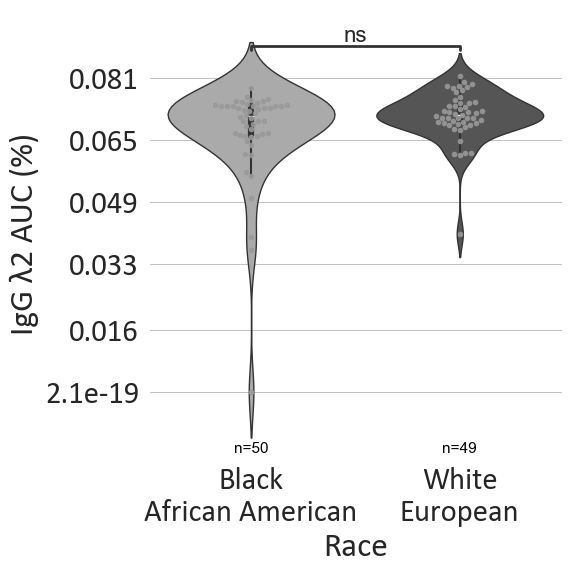

  7%|▋         | 4/54 [00:00<00:02, 20.64it/s]C:\Users\flori\AppData\Local\Temp\ipykernel_30316\3945561324.py:219: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=data, x=x, y=y, hue=hue,


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Black
African American vs. White
European: Mann-Whitney-Wilcoxon test two-sided, P_val:1.072e-04 U_stat=1.779e+03


C:\Users\flori\AppData\Local\Temp\ipykernel_30316\3945561324.py:271: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks, fontdict=ticks_font_params)


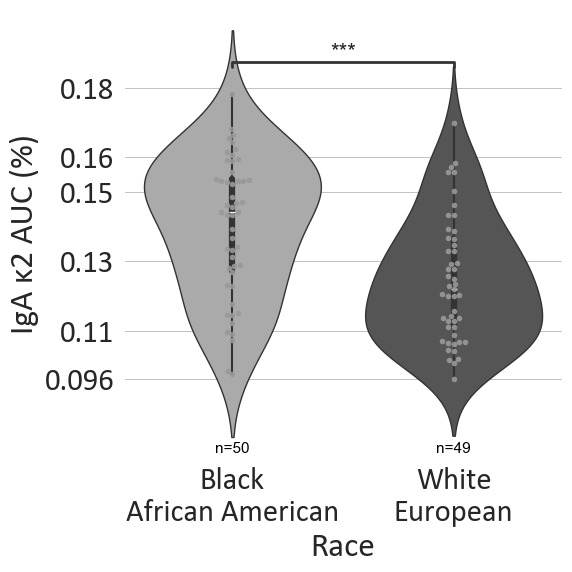

 17%|█▋        | 9/54 [00:00<00:01, 25.76it/s]C:\Users\flori\AppData\Local\Temp\ipykernel_30316\3945561324.py:219: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=data, x=x, y=y, hue=hue,


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Black
African American vs. White
European: Mann-Whitney-Wilcoxon test two-sided, P_val:5.521e-03 U_stat=8.280e+02


C:\Users\flori\AppData\Local\Temp\ipykernel_30316\3945561324.py:271: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks, fontdict=ticks_font_params)


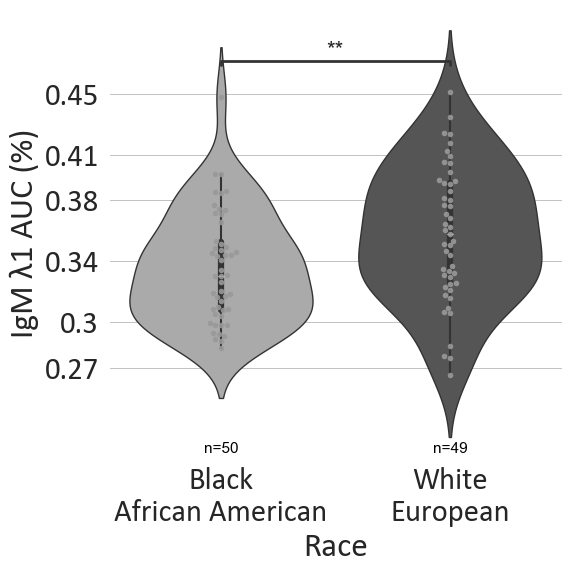

C:\Users\flori\AppData\Local\Temp\ipykernel_30316\3945561324.py:219: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=data, x=x, y=y, hue=hue,
C:\Users\flori\anaconda3\envs\py311_torch21gpu_feb25\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\flori\anaconda3\envs\py311_torch21gpu_feb25\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 30.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\flori\AppData\Local\Temp\ipykernel_30316\3945561324.py:271: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLoca

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Black
African American vs. White
European: Mann-Whitney-Wilcoxon test two-sided, P_val:9.324e-03 U_stat=1.597e+03


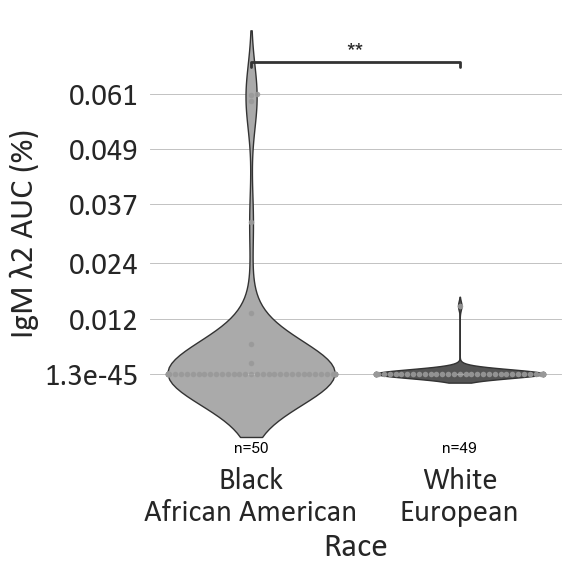

 22%|██▏       | 12/54 [00:00<00:03, 12.07it/s]C:\Users\flori\AppData\Local\Temp\ipykernel_30316\3945561324.py:219: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=data, x=x, y=y, hue=hue,
C:\Users\flori\AppData\Local\Temp\ipykernel_30316\3945561324.py:271: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks, fontdict=ticks_font_params)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Black
African American vs. White
European: Mann-Whitney-Wilcoxon test two-sided, P_val:1.301e-03 U_stat=1.685e+03


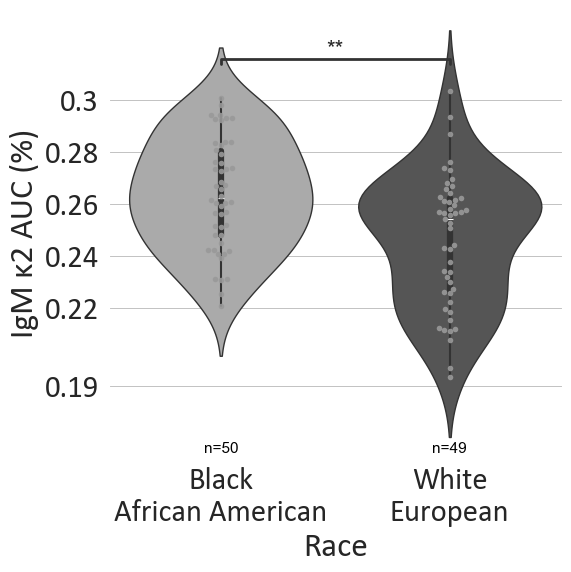

 26%|██▌       | 14/54 [00:01<00:03, 11.77it/s]C:\Users\flori\AppData\Local\Temp\ipykernel_30316\3945561324.py:219: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=data, x=x, y=y, hue=hue,


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Black
African American vs. White
European: Mann-Whitney-Wilcoxon test two-sided, P_val:5.633e-05 U_stat=6.490e+02


C:\Users\flori\AppData\Local\Temp\ipykernel_30316\3945561324.py:271: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks, fontdict=ticks_font_params)


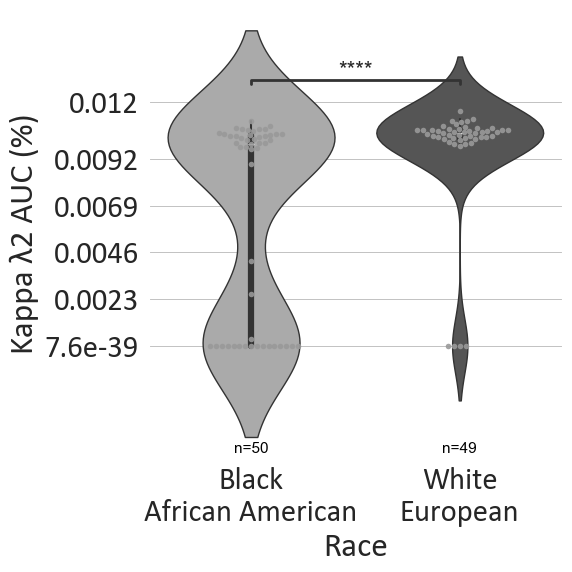

 30%|██▉       | 16/54 [00:01<00:03, 11.16it/s]C:\Users\flori\AppData\Local\Temp\ipykernel_30316\3945561324.py:219: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=data, x=x, y=y, hue=hue,
C:\Users\flori\AppData\Local\Temp\ipykernel_30316\3945561324.py:271: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks, fontdict=ticks_font_params)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Black
African American vs. White
European: Mann-Whitney-Wilcoxon test two-sided, P_val:2.902e-03 U_stat=7.990e+02


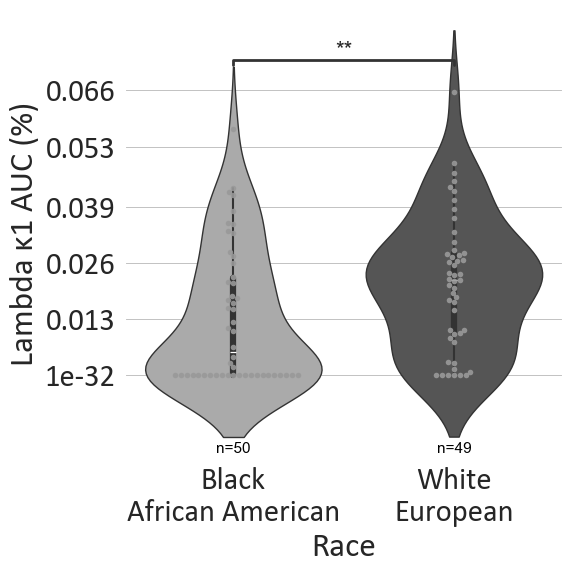

 35%|███▌      | 19/54 [00:01<00:03, 10.12it/s]C:\Users\flori\AppData\Local\Temp\ipykernel_30316\3945561324.py:219: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=data, x=x, y=y, hue=hue,
C:\Users\flori\AppData\Local\Temp\ipykernel_30316\3945561324.py:271: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks, fontdict=ticks_font_params)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Black
African American vs. White
European: Mann-Whitney-Wilcoxon test two-sided, P_val:3.546e-02 U_stat=9.240e+02


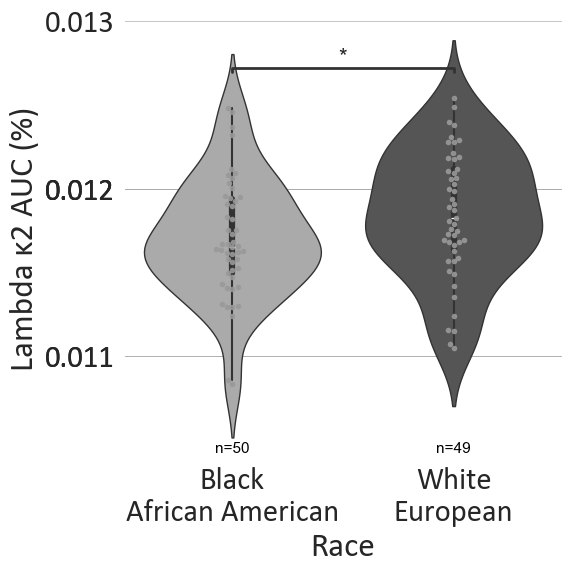

 39%|███▉      | 21/54 [00:01<00:03, 10.58it/s]C:\Users\flori\AppData\Local\Temp\ipykernel_30316\3945561324.py:219: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=data, x=x, y=y, hue=hue,


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Black
African American vs. White
European: Mann-Whitney-Wilcoxon test two-sided, P_val:5.633e-05 U_stat=1.801e+03


C:\Users\flori\AppData\Local\Temp\ipykernel_30316\3945561324.py:271: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks, fontdict=ticks_font_params)


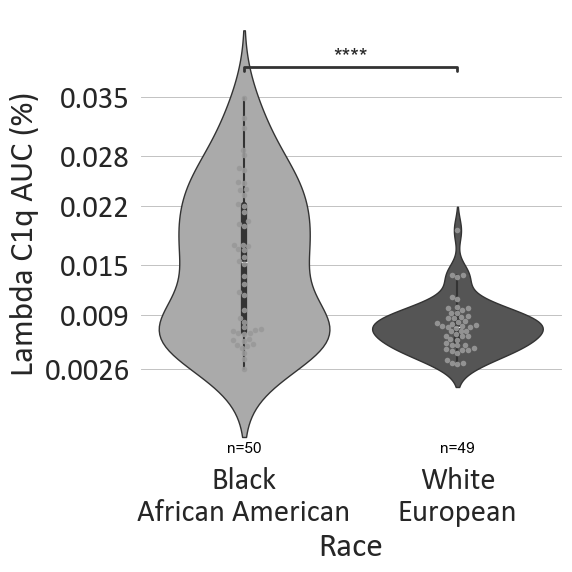

C:\Users\flori\AppData\Local\Temp\ipykernel_30316\3945561324.py:219: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=data, x=x, y=y, hue=hue,
C:\Users\flori\AppData\Local\Temp\ipykernel_30316\3945561324.py:271: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks, fontdict=ticks_font_params)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Black
African American vs. White
European: Mann-Whitney-Wilcoxon test two-sided, P_val:6.010e-03 U_stat=8.415e+02


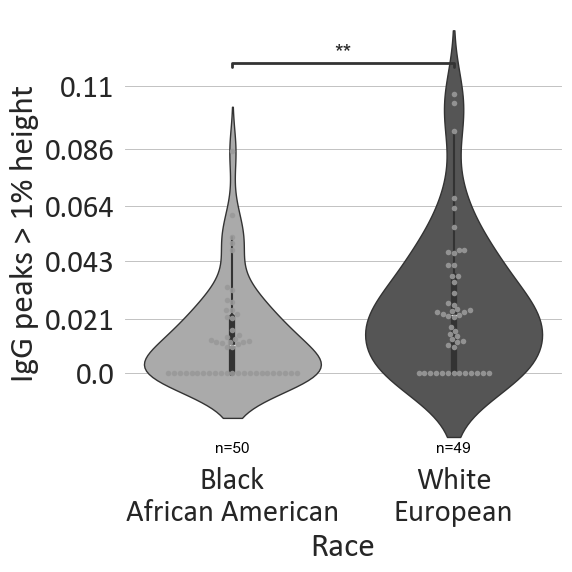

 43%|████▎     | 23/54 [00:02<00:03,  8.60it/s]C:\Users\flori\AppData\Local\Temp\ipykernel_30316\3945561324.py:219: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=data, x=x, y=y, hue=hue,
C:\Users\flori\AppData\Local\Temp\ipykernel_30316\3945561324.py:271: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks, fontdict=ticks_font_params)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Black
African American vs. White
European: Mann-Whitney-Wilcoxon test two-sided, P_val:1.991e-04 U_stat=6.930e+02


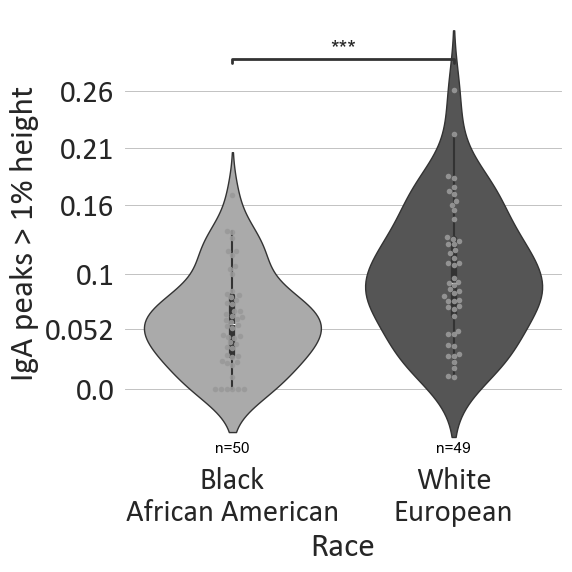

 44%|████▍     | 24/54 [00:02<00:03,  8.10it/s]C:\Users\flori\AppData\Local\Temp\ipykernel_30316\3945561324.py:219: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=data, x=x, y=y, hue=hue,
C:\Users\flori\AppData\Local\Temp\ipykernel_30316\3945561324.py:271: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks, fontdict=ticks_font_params)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Black
African American vs. White
European: Mann-Whitney-Wilcoxon test two-sided, P_val:2.273e-02 U_stat=1.551e+03


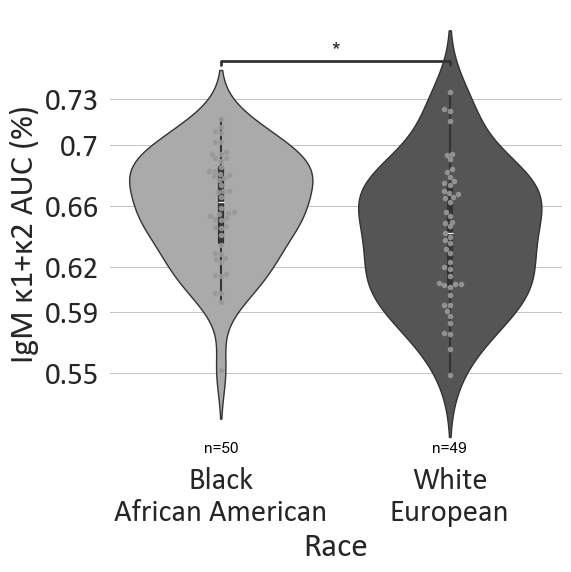

 59%|█████▉    | 32/54 [00:02<00:01, 17.61it/s]C:\Users\flori\AppData\Local\Temp\ipykernel_30316\3945561324.py:219: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=data, x=x, y=y, hue=hue,
C:\Users\flori\AppData\Local\Temp\ipykernel_30316\3945561324.py:271: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks, fontdict=ticks_font_params)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Black
African American vs. White
European: Mann-Whitney-Wilcoxon test two-sided, P_val:2.190e-02 U_stat=8.970e+02


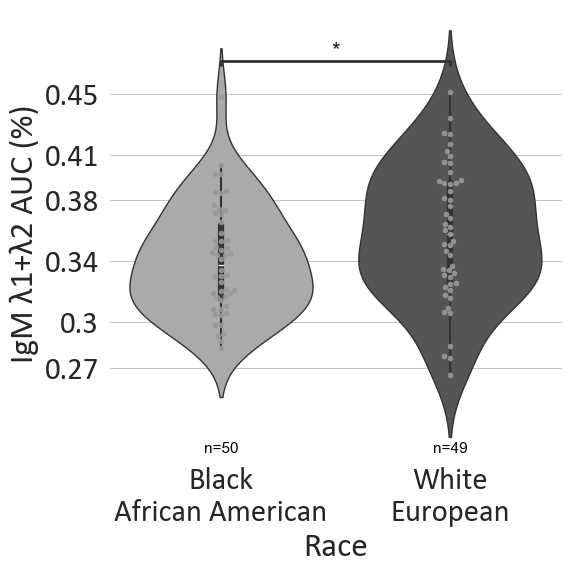

C:\Users\flori\AppData\Local\Temp\ipykernel_30316\3945561324.py:219: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=data, x=x, y=y, hue=hue,
C:\Users\flori\AppData\Local\Temp\ipykernel_30316\3945561324.py:271: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks, fontdict=ticks_font_params)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Black
African American vs. White
European: Mann-Whitney-Wilcoxon test two-sided, P_val:2.231e-02 U_stat=8.980e+02


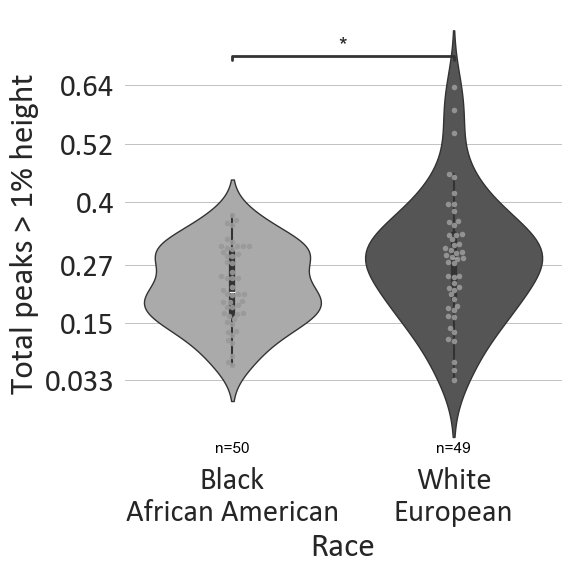

 65%|██████▍   | 35/54 [00:02<00:01, 14.61it/s]C:\Users\flori\AppData\Local\Temp\ipykernel_30316\3945561324.py:219: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=data, x=x, y=y, hue=hue,
C:\Users\flori\AppData\Local\Temp\ipykernel_30316\3945561324.py:271: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks, fontdict=ticks_font_params)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Black
African American vs. White
European: Mann-Whitney-Wilcoxon test two-sided, P_val:2.167e-04 U_stat=1.754e+03


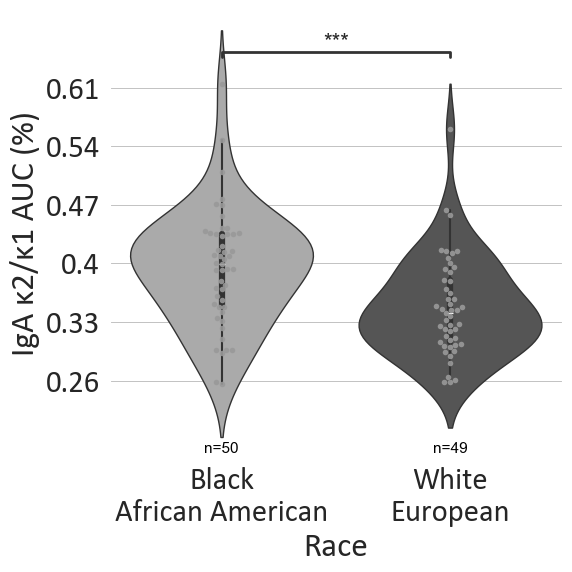

 70%|███████   | 38/54 [00:02<00:01, 15.55it/s]C:\Users\flori\AppData\Local\Temp\ipykernel_30316\3945561324.py:219: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=data, x=x, y=y, hue=hue,


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Black
African American vs. White
European: Mann-Whitney-Wilcoxon test two-sided, P_val:1.336e-02 U_stat=1.579e+03


C:\Users\flori\AppData\Local\Temp\ipykernel_30316\3945561324.py:271: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks, fontdict=ticks_font_params)


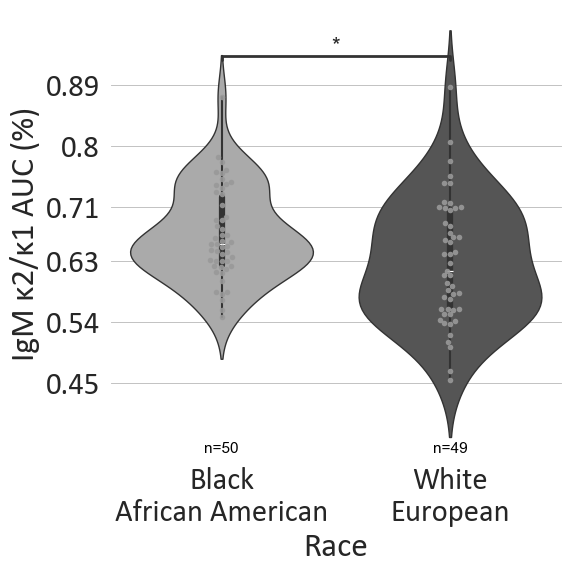

 76%|███████▌  | 41/54 [00:03<00:00, 16.33it/s]C:\Users\flori\AppData\Local\Temp\ipykernel_30316\3945561324.py:219: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=data, x=x, y=y, hue=hue,
C:\Users\flori\anaconda3\envs\py311_torch21gpu_feb25\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\flori\anaconda3\envs\py311_torch21gpu_feb25\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 30.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\flori\AppData\Local\Temp\ipykernel_30316\3945561324.py:271: UserWarning: set_ticklabels() should only be used with a fixed number of tic

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Black
African American vs. White
European: Mann-Whitney-Wilcoxon test two-sided, P_val:8.768e-03 U_stat=1.600e+03


C:\Users\flori\anaconda3\envs\py311_torch21gpu_feb25\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\flori\anaconda3\envs\py311_torch21gpu_feb25\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 30.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\flori\anaconda3\envs\py311_torch21gpu_feb25\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 28.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\flori\anaconda3\envs\py311_torch21gpu_feb25\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 38.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserW

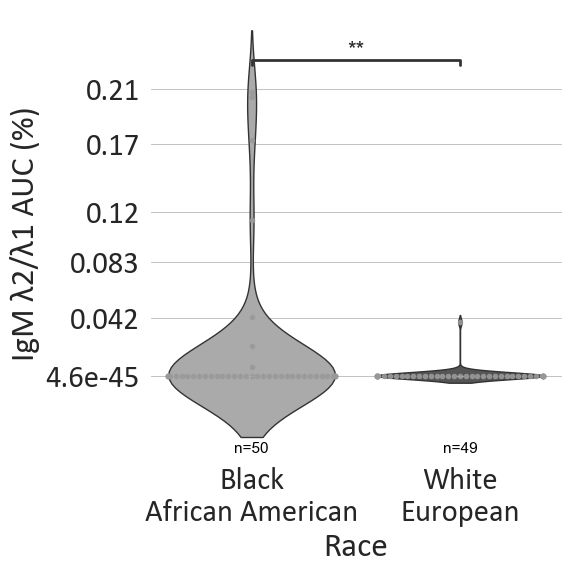

C:\Users\flori\AppData\Local\Temp\ipykernel_30316\3945561324.py:219: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=data, x=x, y=y, hue=hue,
C:\Users\flori\AppData\Local\Temp\ipykernel_30316\3945561324.py:271: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks, fontdict=ticks_font_params)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Black
African American vs. White
European: Mann-Whitney-Wilcoxon test two-sided, P_val:2.150e-02 U_stat=1.554e+03


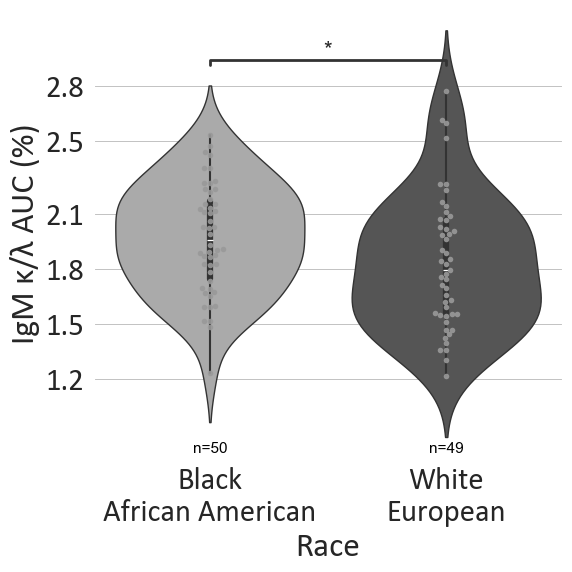

 80%|███████▉  | 43/54 [00:03<00:01, 10.32it/s]C:\Users\flori\AppData\Local\Temp\ipykernel_30316\3945561324.py:219: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=data, x=x, y=y, hue=hue,
C:\Users\flori\AppData\Local\Temp\ipykernel_30316\3945561324.py:271: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks, fontdict=ticks_font_params)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Black
African American vs. White
European: Mann-Whitney-Wilcoxon test two-sided, P_val:7.860e-12 U_stat=2.203e+03


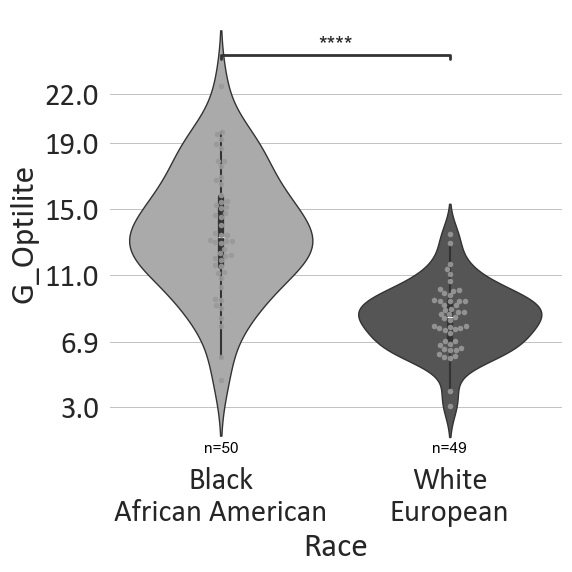

 85%|████████▌ | 46/54 [00:03<00:00, 11.98it/s]C:\Users\flori\AppData\Local\Temp\ipykernel_30316\3945561324.py:219: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=data, x=x, y=y, hue=hue,
C:\Users\flori\AppData\Local\Temp\ipykernel_30316\3945561324.py:271: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks, fontdict=ticks_font_params)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Black
African American vs. White
European: Mann-Whitney-Wilcoxon test two-sided, P_val:3.439e-04 U_stat=1.737e+03


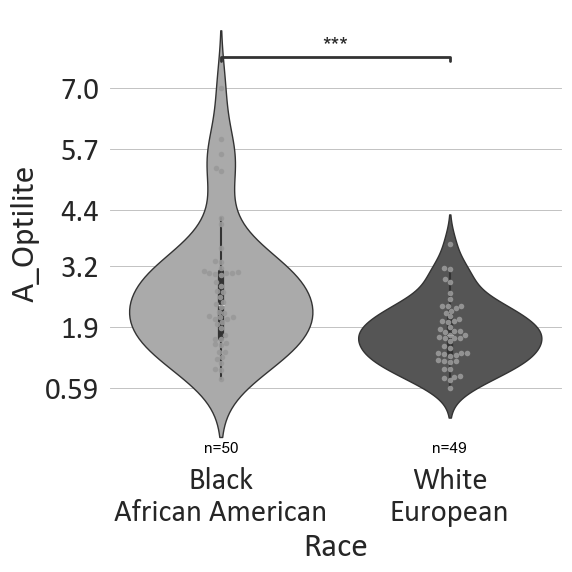

 89%|████████▉ | 48/54 [00:03<00:00, 12.14it/s]C:\Users\flori\AppData\Local\Temp\ipykernel_30316\3945561324.py:219: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=data, x=x, y=y, hue=hue,
C:\Users\flori\AppData\Local\Temp\ipykernel_30316\3945561324.py:271: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks, fontdict=ticks_font_params)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Black
African American vs. White
European: Mann-Whitney-Wilcoxon test two-sided, P_val:1.341e-11 U_stat=2.192e+03


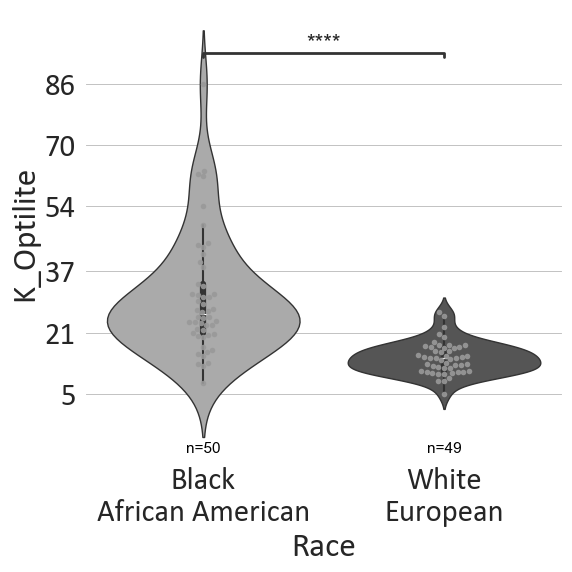

C:\Users\flori\AppData\Local\Temp\ipykernel_30316\3945561324.py:219: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=data, x=x, y=y, hue=hue,
C:\Users\flori\AppData\Local\Temp\ipykernel_30316\3945561324.py:271: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks, fontdict=ticks_font_params)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Black
African American vs. White
European: Mann-Whitney-Wilcoxon test two-sided, P_val:5.719e-07 U_stat=1.940e+03


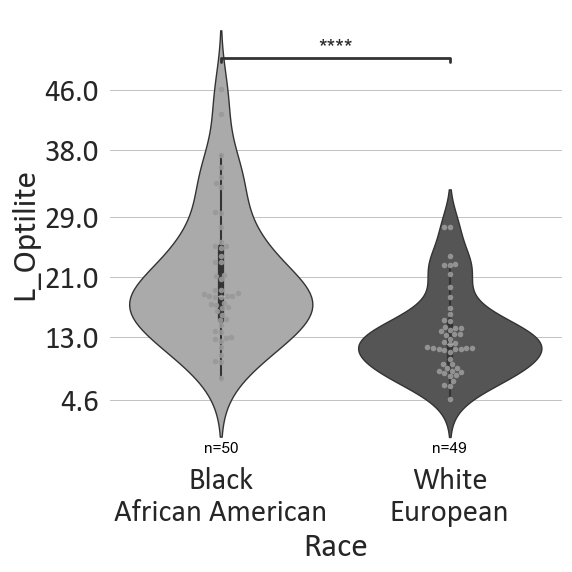

 93%|█████████▎| 50/54 [00:04<00:00,  9.79it/s]C:\Users\flori\AppData\Local\Temp\ipykernel_30316\3945561324.py:219: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=data, x=x, y=y, hue=hue,
C:\Users\flori\AppData\Local\Temp\ipykernel_30316\3945561324.py:271: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks, fontdict=ticks_font_params)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Black
African American vs. White
European: Mann-Whitney-Wilcoxon test two-sided, P_val:1.218e-11 U_stat=2.194e+03


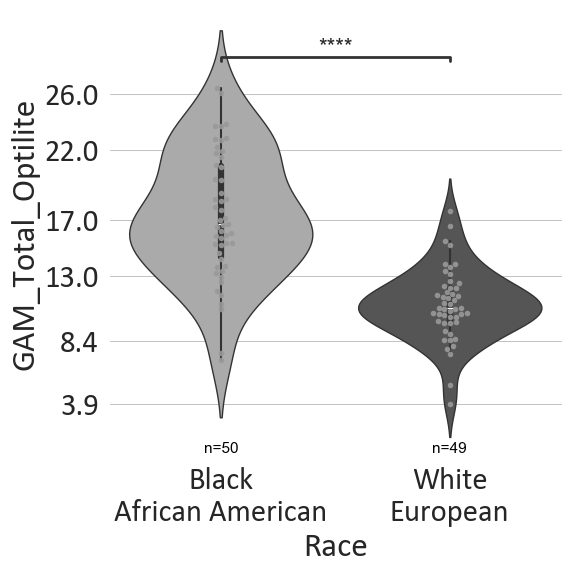

C:\Users\flori\AppData\Local\Temp\ipykernel_30316\3945561324.py:219: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=data, x=x, y=y, hue=hue,
C:\Users\flori\AppData\Local\Temp\ipykernel_30316\3945561324.py:271: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks, fontdict=ticks_font_params)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Black
African American vs. White
European: Mann-Whitney-Wilcoxon test two-sided, P_val:1.688e-04 U_stat=1.763e+03


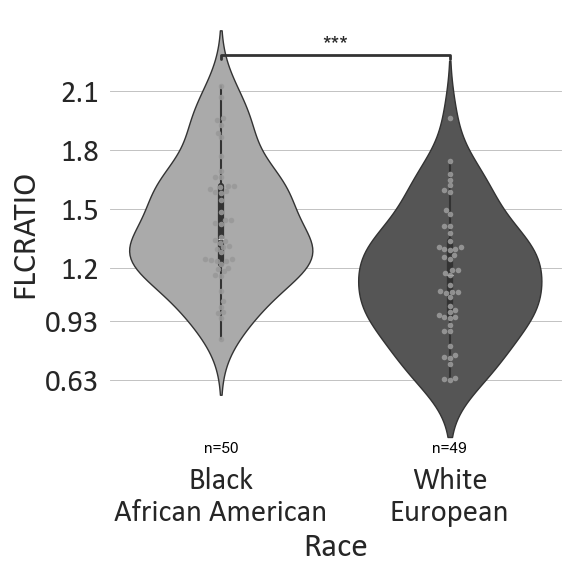

 96%|█████████▋| 52/54 [00:04<00:00,  8.54it/s]C:\Users\flori\AppData\Local\Temp\ipykernel_30316\3945561324.py:219: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=data, x=x, y=y, hue=hue,
C:\Users\flori\AppData\Local\Temp\ipykernel_30316\3945561324.py:271: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks, fontdict=ticks_font_params)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Black
African American vs. White
European: Mann-Whitney-Wilcoxon test two-sided, P_val:2.535e-02 U_stat=1.545e+03


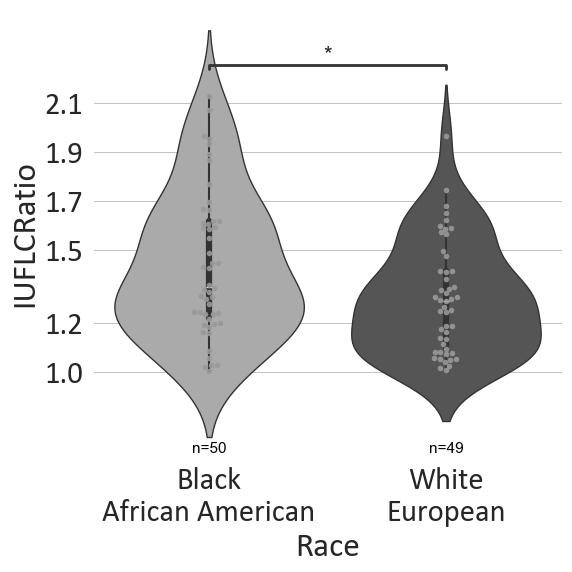

100%|██████████| 54/54 [00:04<00:00, 11.68it/s]


In [35]:
# compute the determination coef (r2) for all variables vs our target variable (age or humoral age)

covariates_metric_list = []
for feature in tqdm(candidate_features):
    feature_filename = feature.replace(" >", "").replace("/", "_")
    # get the values of interest
    y = feature_exploration_df[target_score_colname]
    if feature_exploration_mode == "qualitative":
        y = y.apply(lambda v: "Positive" if v > .5 else "Negative")
    x = trace_features_analysis_df_enriched[feature]
    # check if some variance
    # compute pearson's r
    if feature_exploration_mode == "quantitative":
        val_r = scipy.stats.pearsonr(x, y).statistic
        feature_metric = val_r ** 2
    elif feature_exploration_mode == "qualitative":
        val_p = scipy.stats.ttest_ind(x[y == "Positive"].values, x[y == "Negative"].values).pvalue
        feature_metric = -np.log10(val_p)
    else:
        assert False
    if np.std(x) == 0:
        print(f"Skipping {feature=}: zero-variance")
        covariates_metric_list.append(0)  # put a dummy "zero" value to avoid "nan"'s
        continue
    # save the r2 in a list
    covariates_metric_list.append(feature_metric)
    if (feature_exploration_mode == "quantitative") or (feature_metric < 1.2):  # plot only if r² >= 0.1
        continue
    # prepare the plot
    # create a correlation plot between this feature and the target variable
    plt.figure(figsize=(pp_size, pp_size))
    if target_score_colname == "Age score":
        yticks = [-2, -1, 0, 1, 2]
    elif target_score_colname == "Age":
        yticks = [40, 50, 65, 75]
    xmin, xmax = x.min(), x.max()
    xrange = xmax - xmin
    xticks = np.arange(xmin, xmax + (xrange / 5) / 2, xrange / 5)
    xticks = [float(f"{v:.2g}") for v in xticks]
    if feature_exploration_mode == "quantitative":
        plot_lm(x=x, y=y, group_name="Negatives", xticks=xticks, yticks=yticks,
                ylabel="BiAge" if target_score_colname == "Age score" else target_score_colname,
                xlabel=feature,
                text_bbox_alpha=.8,
                text_show_sample_size=False,
                confidence_level=.99)
    elif feature_exploration_mode == "qualitative":
        if target_score_colname == 'Black/African American probability':
            y_mapped = y.map({"Positive": "Black\nAfrican American", "Negative": "White\nEuropean"})
            y_mapped = y_mapped.astype("category").cat.set_categories(["Black\nAfrican American", "White\nEuropean"])
            box_pairs = [("Black\nAfrican American", "White\nEuropean",), ]
            boxplot_data = pd.concat([x, y_mapped], axis=1)
            boxplot_kwargs = {"data": boxplot_data, "x": target_score_colname, "y": feature, "hue": None}
        elif target_score_colname == 'Binary race':
            y_mapped = y.map({"Positive": "Black\nAfrican American", "Negative": "White\nEuropean"})
            y_mapped = y_mapped.astype("category").cat.set_categories(["Black\nAfrican American", "White\nEuropean"])
            box_pairs = [("Black\nAfrican American", "White\nEuropean",), ]
            boxplot_data = pd.concat([x, y_mapped], axis=1)
            boxplot_kwargs = {"data": boxplot_data, "x": target_score_colname, "y": feature, "hue": None}
        elif target_score_colname == 'Sex score':
            y_mapped = y.map({"Positive": "Female", "Negative": "Male"})
            y_mapped = y_mapped.astype("category").cat.set_categories(["Female", "Male"])
            box_pairs = [("Female", "Male",), ]
            boxplot_data = pd.concat([x, y_mapped], axis=1)
            boxplot_kwargs = {"data": boxplot_data, "x": target_score_colname, "y": feature, "hue": None}
        else:
            assert False, "Uncoded yet"
        ax = plot_box(**boxplot_kwargs,
                      legend_off=True,
                      yticks=xticks,
                      xlabel="Race" if target_score_colname == "Black/African American probability" else "Self-declared\nrace" if target_score_colname == "Binary race" else "Sex" if target_score_colname == "Sex score" else "?",
                      ylabel=feature,
                      palette="binary",
                      # subtype="precise_violinplot",
                      subtype="precise_violinplot+swarmplot",
                      swarmsize=4)
        # p value
        if statannotations_available:
            annotator2 = Annotator(ax, box_pairs, **boxplot_kwargs)
            annotator2.configure(test='Mann-Whitney', text_format='star', loc='inside',
                                 line_width=2.0, line_height=.01, text_offset=0)
            annotator2.apply_and_annotate()
    plt.tight_layout()
    plt.show()
    
covariates_metric_list = np.array(covariates_metric_list)